In [327]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy import ndimage

In [112]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import TensorDataset, DataLoader
from functools import partial
from collections import defaultdict

## Net

In [52]:
class Flatten(nn.Module):
    """Converts N-dimensional tensor into 'flat' one."""

    def __init__(self, keep_batch_dim=True):
        super().__init__()
        self.keep_batch_dim = keep_batch_dim

    def forward(self, x):
        if self.keep_batch_dim:
            return x.view(x.size(0), -1)
        return x.view(-1)

In [144]:
def create_datasets(data, target, train_size,test, valid_pct=0.1, seed=None):
    """Converts NumPy arrays into PyTorch datsets.
    
    Three datasets are created in total:
        * training dataset
        * validation dataset
        * testing (un-labelled) dataset

    """
    raw, fft = data
    assert len(raw) == len(fft)
    sz = train_size
    idx = np.arange(sz)
    trn_idx, val_idx = train_test_split(
        idx, test_size=valid_pct, random_state=seed)
    trn_ds = TensorDataset(
        torch.tensor(raw[:sz][trn_idx]).float(), 
        torch.tensor(fft[:sz][trn_idx]).float(), 
        torch.tensor(target[:sz][trn_idx]).long())
    val_ds = TensorDataset(
        torch.tensor(raw[:sz][val_idx]).float(), 
        torch.tensor(fft[:sz][val_idx]).float(), 
        torch.tensor(target[:sz][val_idx]).long())
    tst_ds = TensorDataset(
        torch.tensor(test[0]).float(), 
        torch.tensor(test[1]).float(), 
        torch.tensor(test[2]).long())
    return trn_ds, val_ds, tst_ds

In [69]:
def create_loaders(data, bs=128, jobs=0):
    """Wraps the datasets returned by create_datasets function with data loaders."""
    
    trn_ds, val_ds, tst_ds = data
    trn_dl = DataLoader(trn_ds, batch_size=bs, shuffle=True, num_workers=jobs)
    val_dl = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    tst_dl = DataLoader(tst_ds, batch_size=bs, shuffle=False, num_workers=jobs)
    return trn_dl, val_dl, tst_dl


# Flow

In [648]:
def calculate_primitive_spectrogram(row, window_length):
    row = np.array(row)
    spectrogram = np.zeros(row.shape[0])
    adopted = np.concatenate([np.zeros(window_length-1), row, np.zeros(window_length-1)])
    for i in range(row.shape[0]):
        a = np.abs(np.fft.fft(adopted[i:i+window_length-1]))
        spectrogram[i] = np.argmax(medfilt(a,kernel_size=(21)))
    k = 2
    kern = np.ones(2*k+1)/(2*k+1)
    return np.convolve(spectrogram,kern, mode='same')

In [649]:
from scipy.signal import medfilt

In [650]:
all_df = pd.read_csv('train.csv')
all_df = all_df.fillna(0).sample(frac=1)
y = all_df['label']
X = all_df.drop(columns = 'label')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)



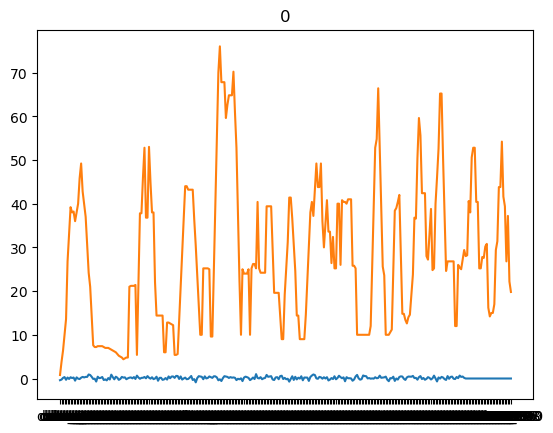

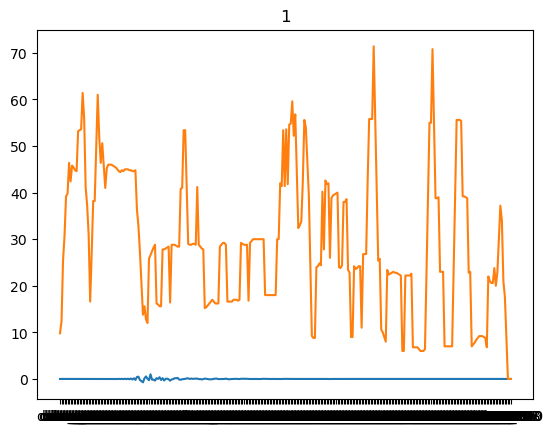

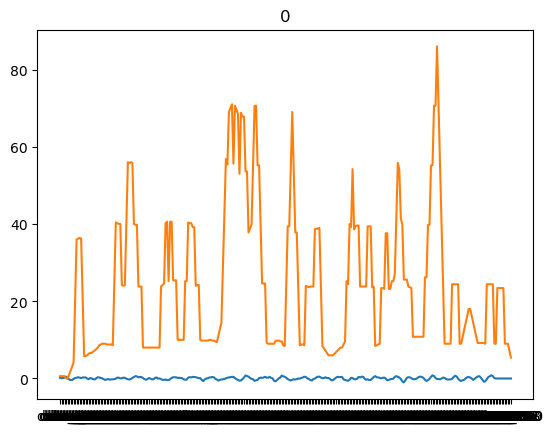

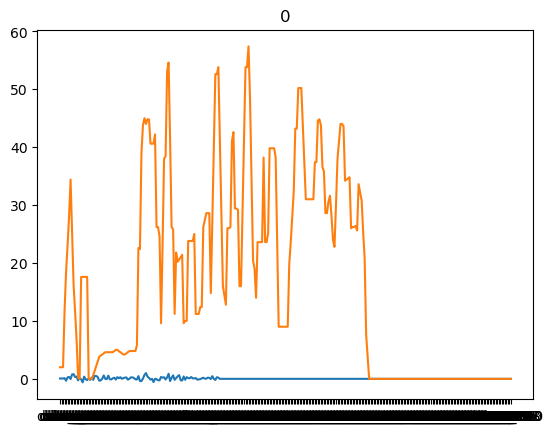

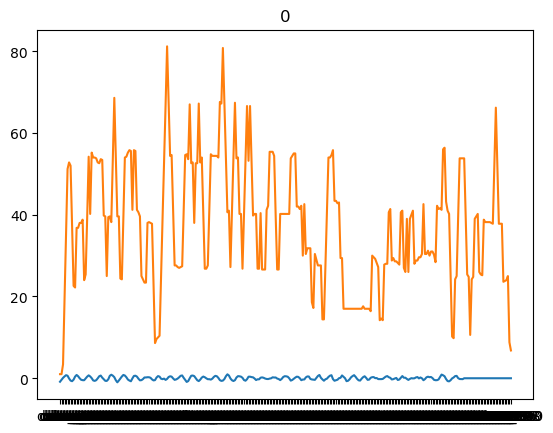

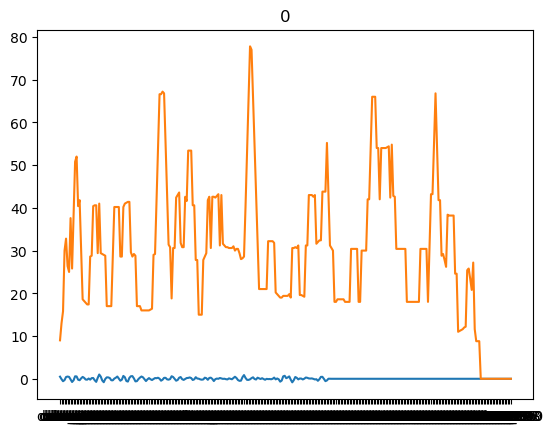

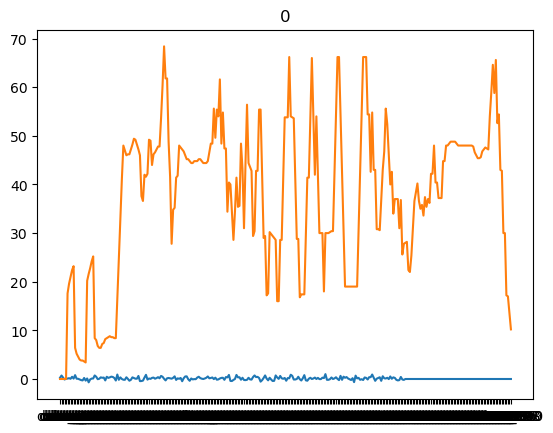

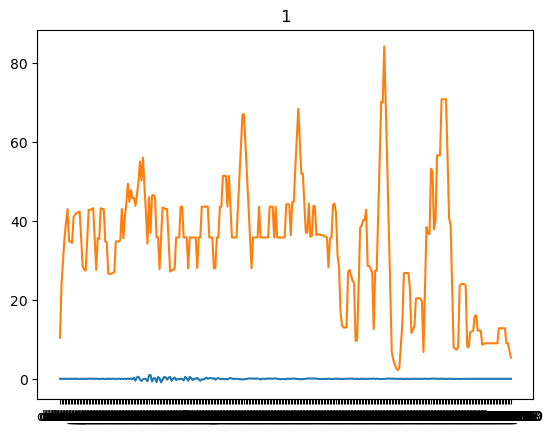

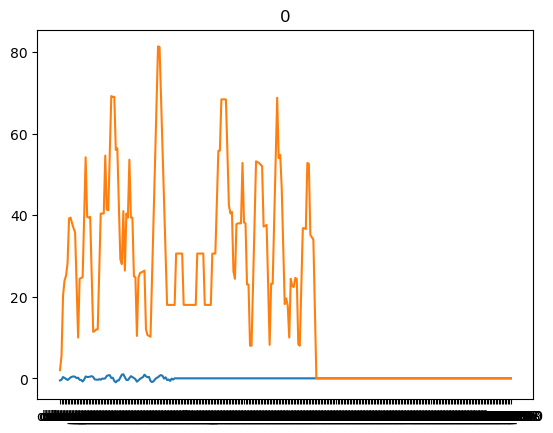

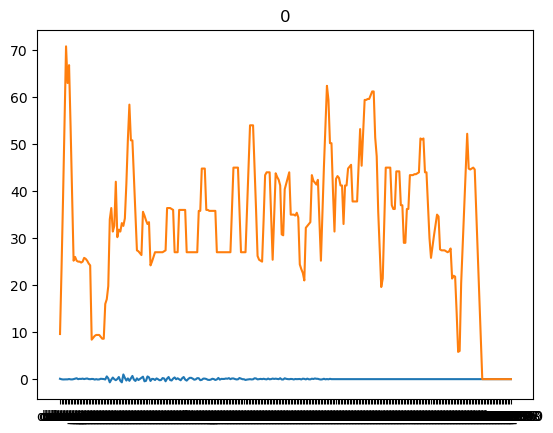

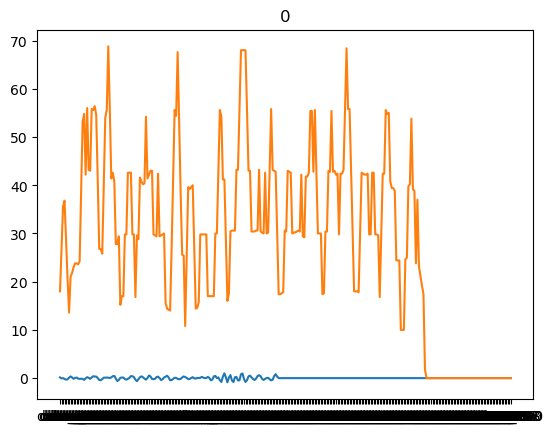

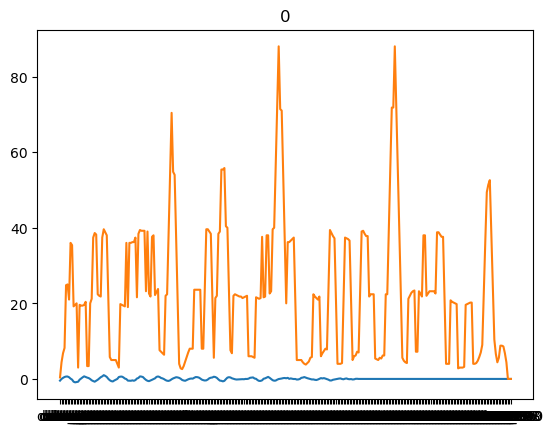

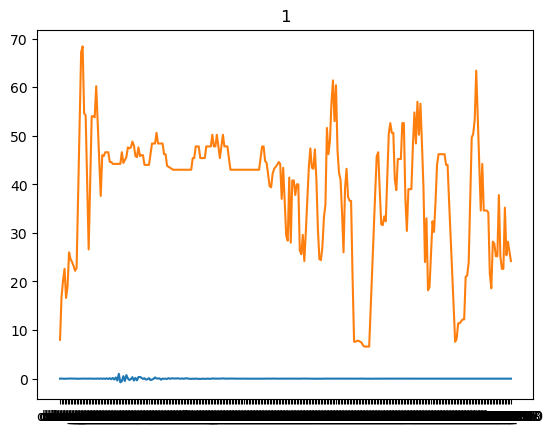

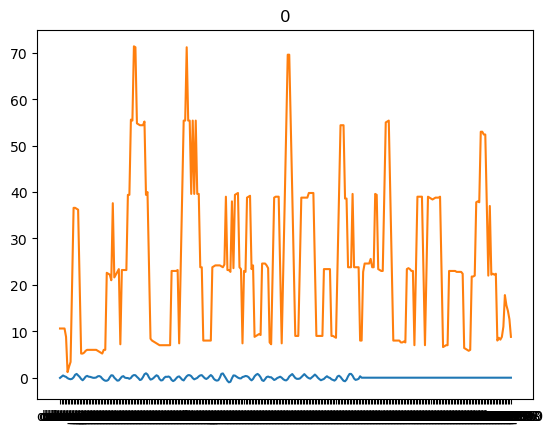

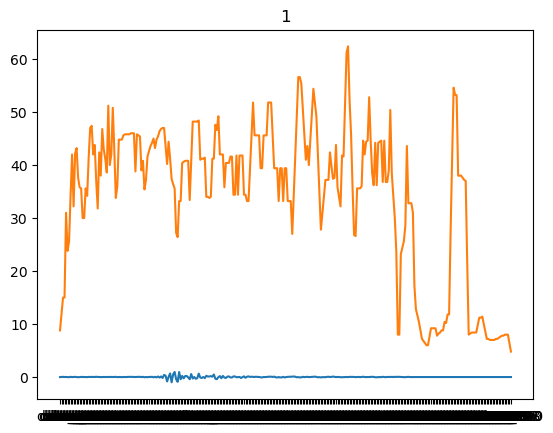

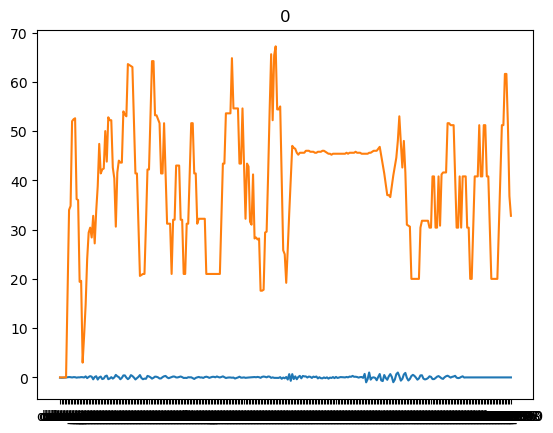

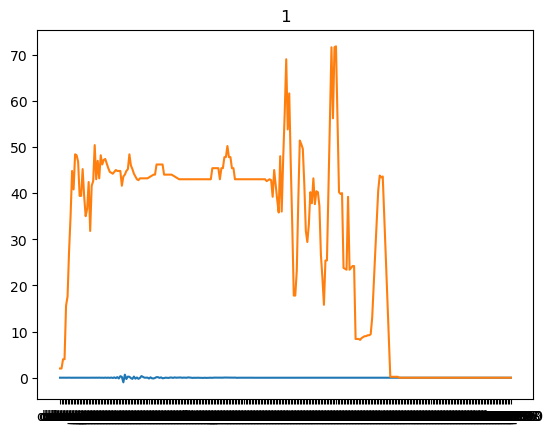

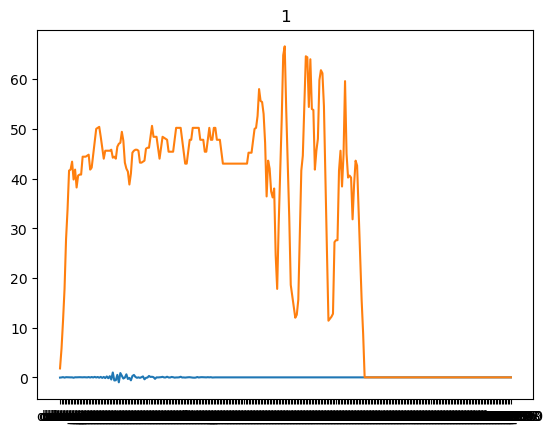

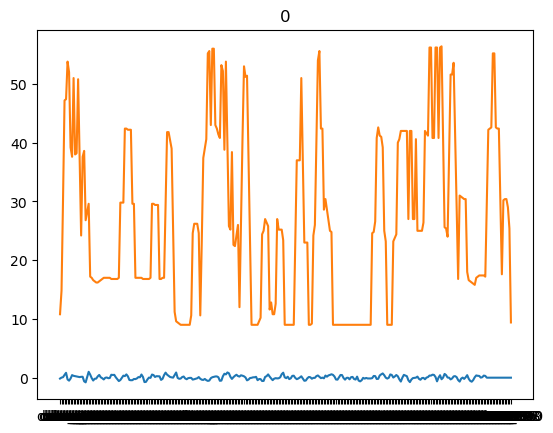

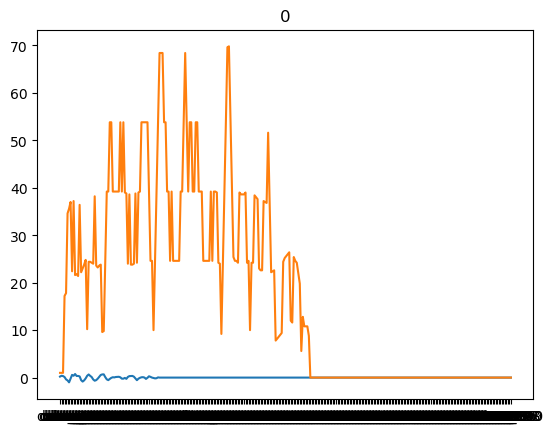

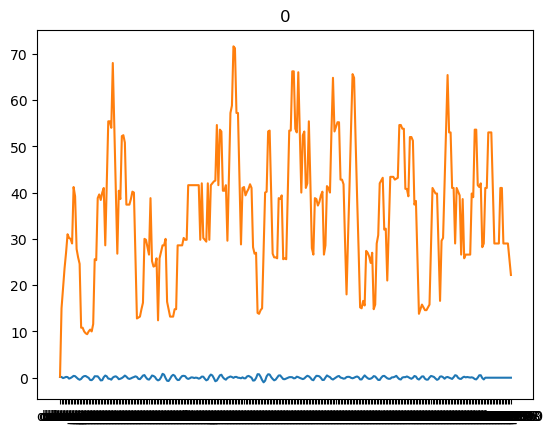

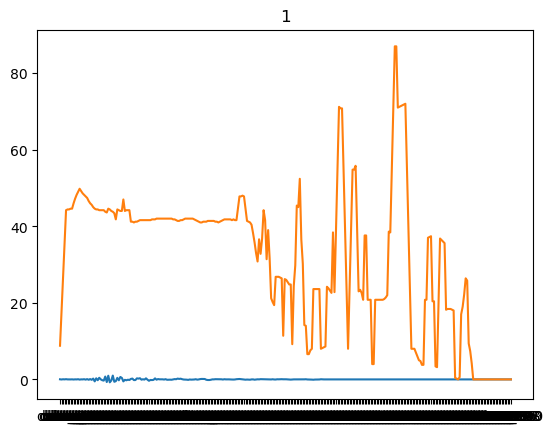

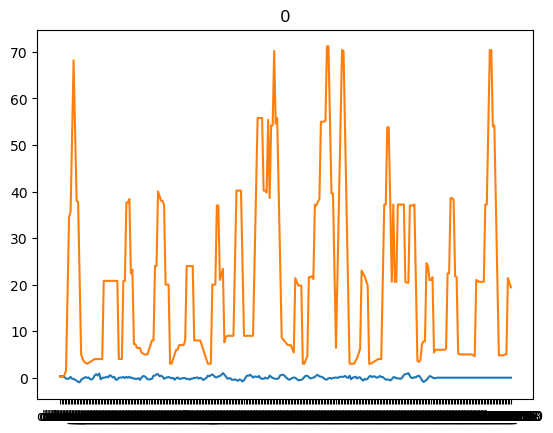

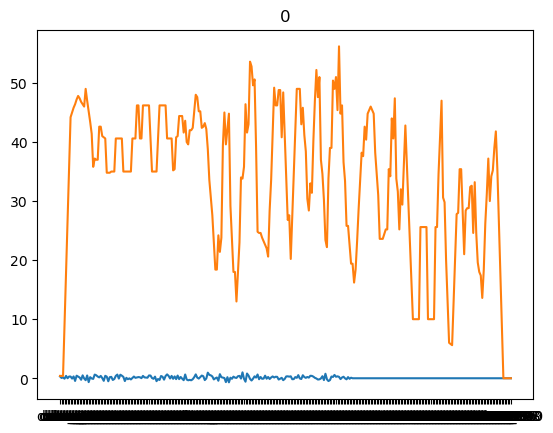

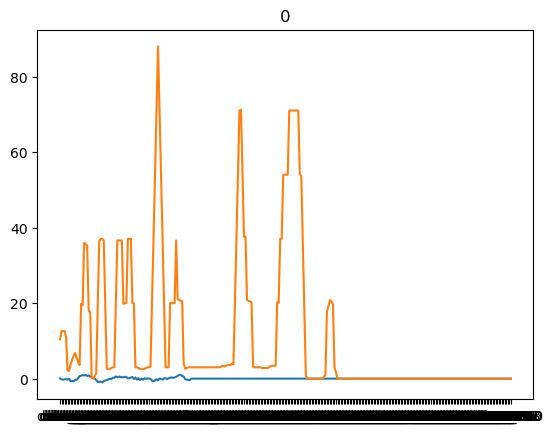

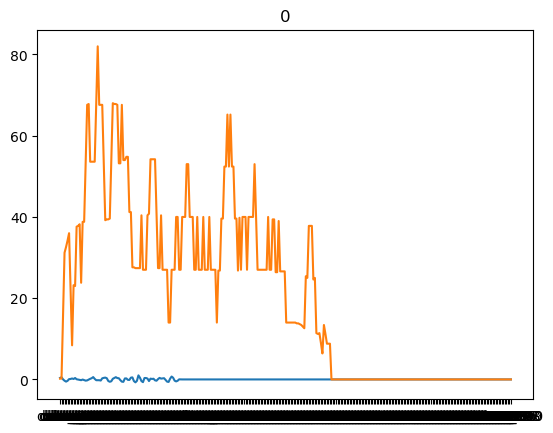

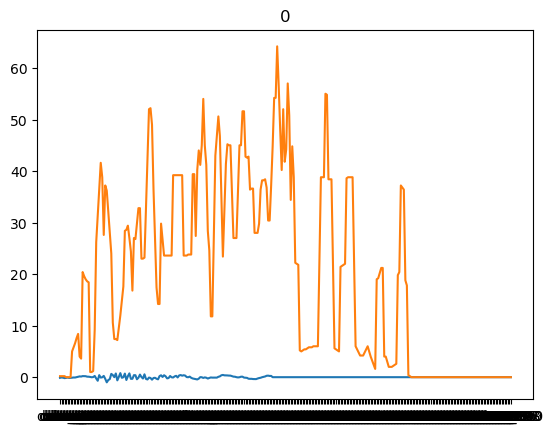

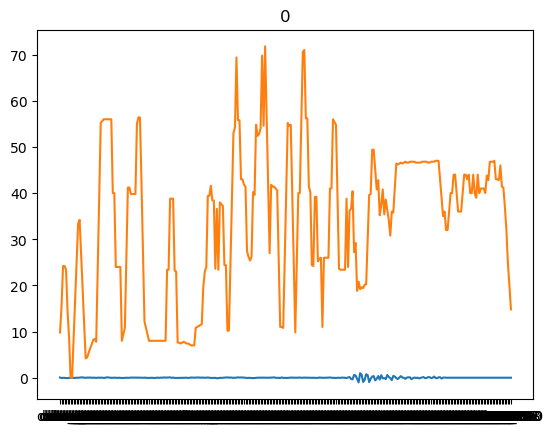

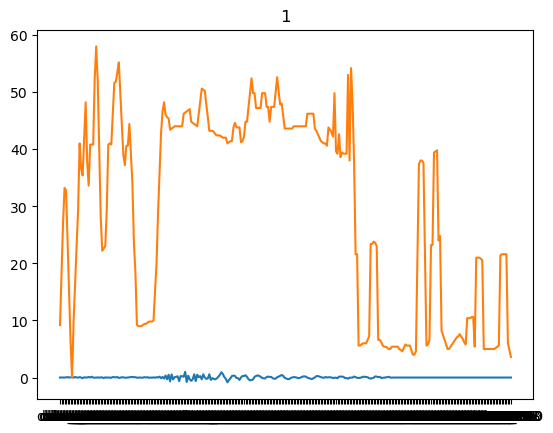

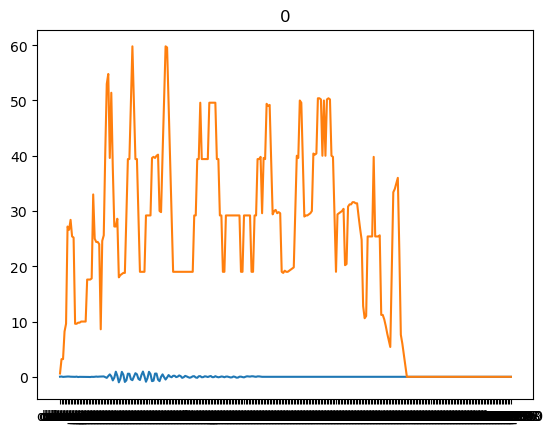

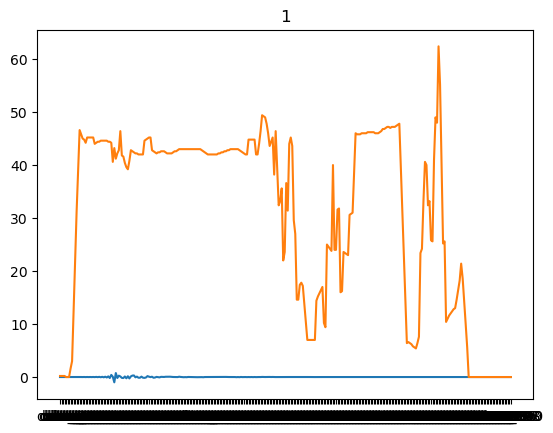

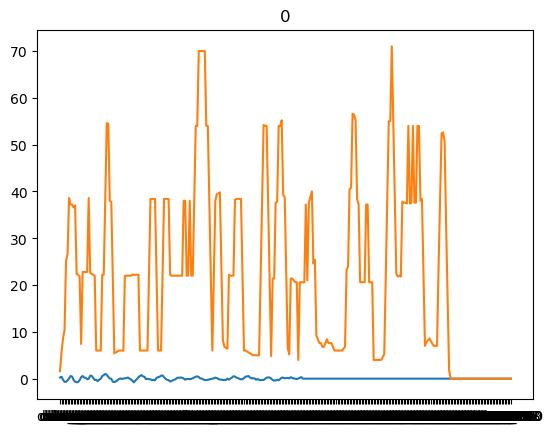

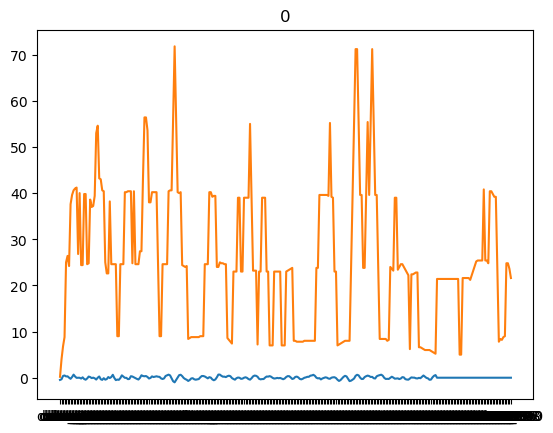

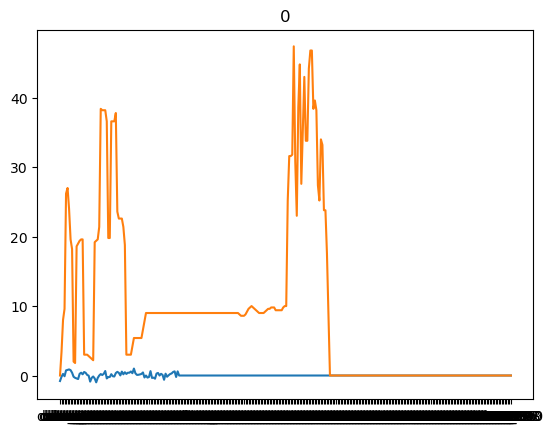

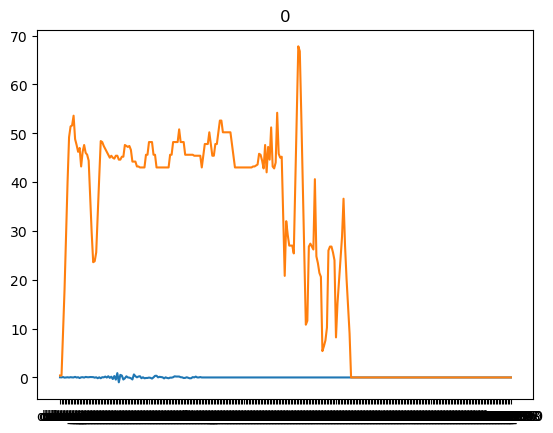

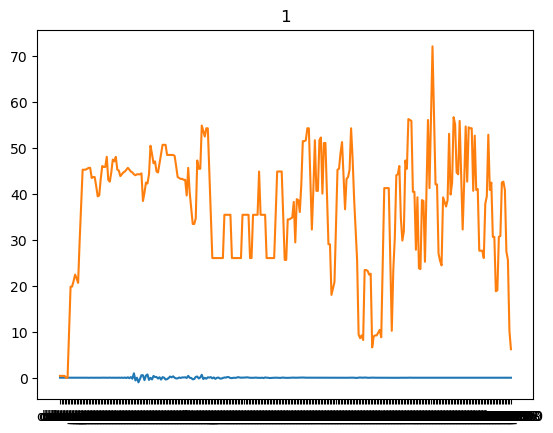

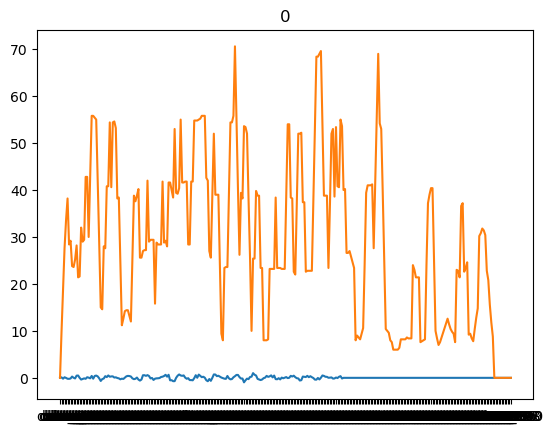

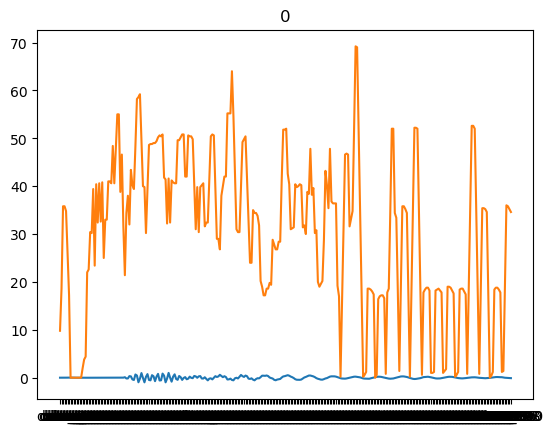

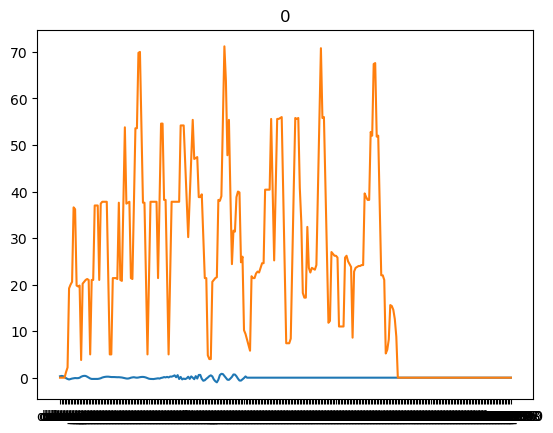

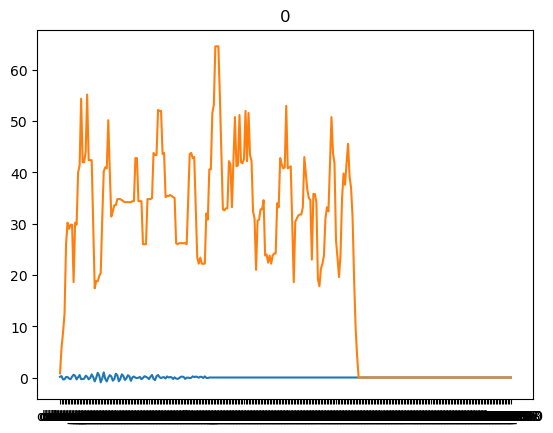

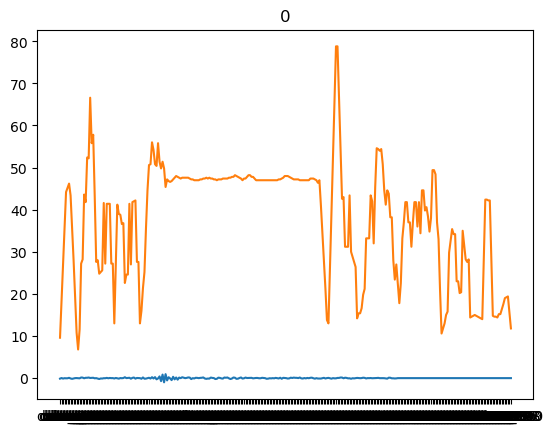

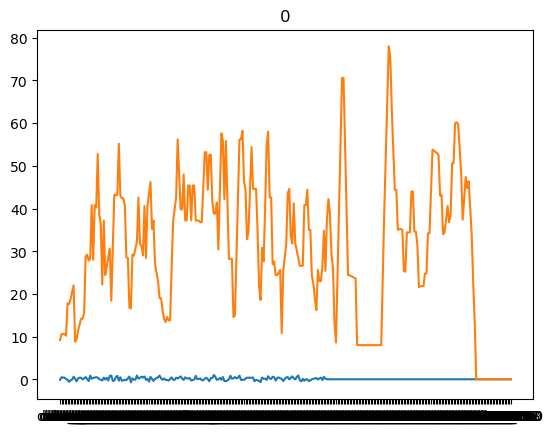

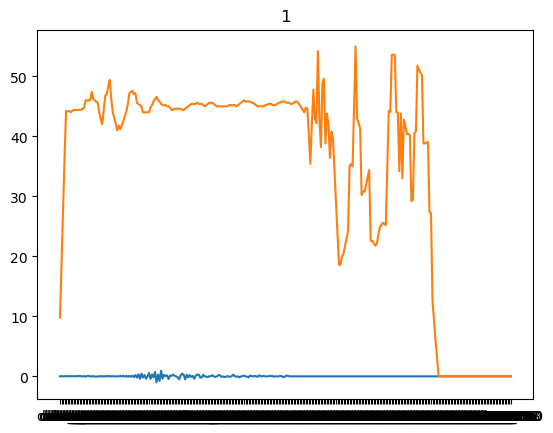

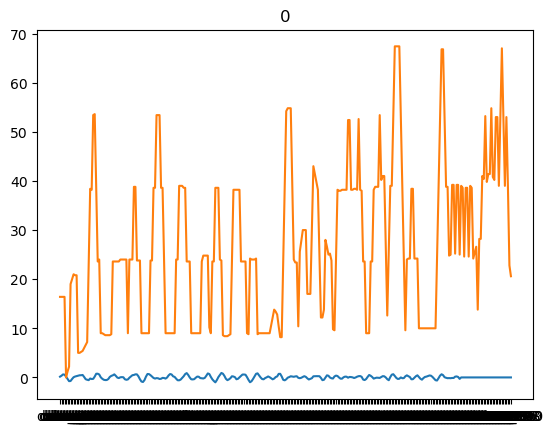

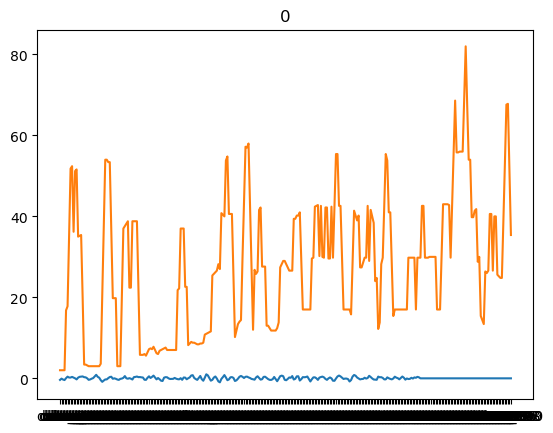

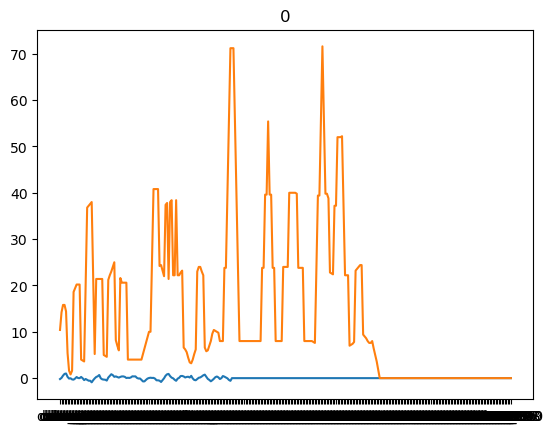

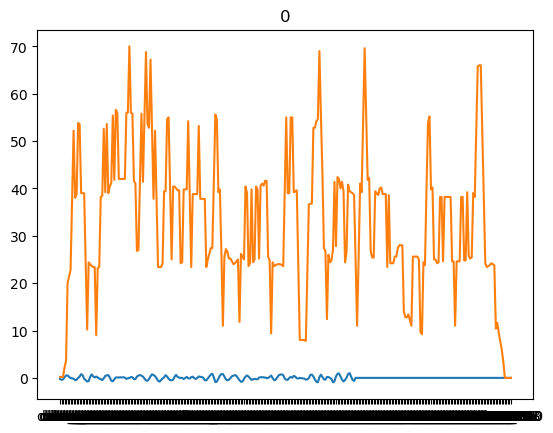

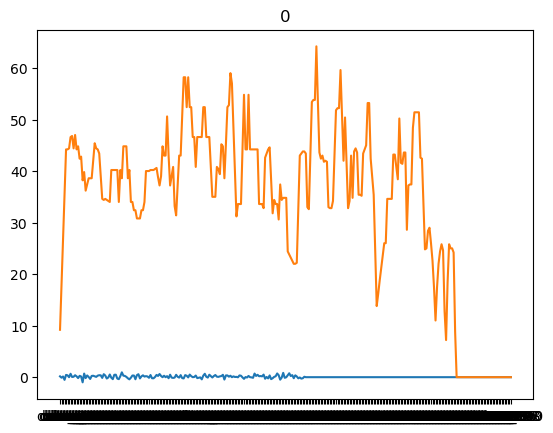

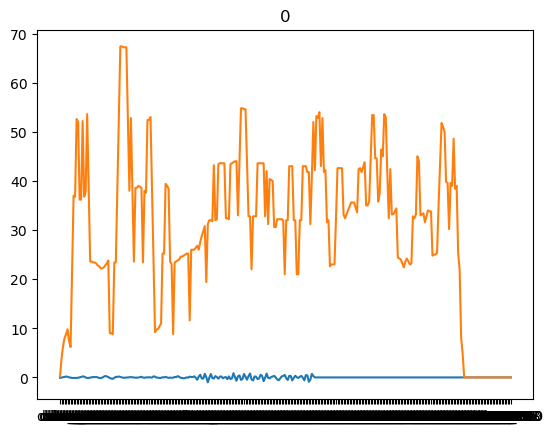

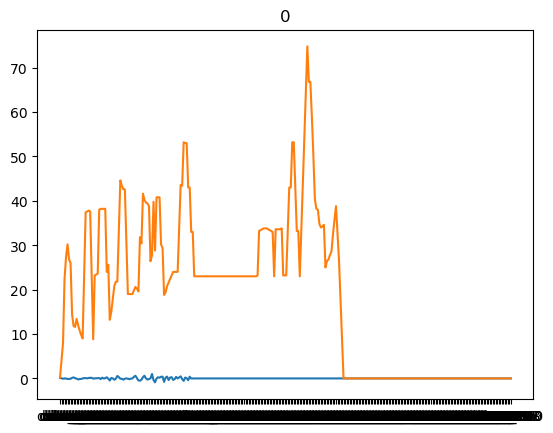

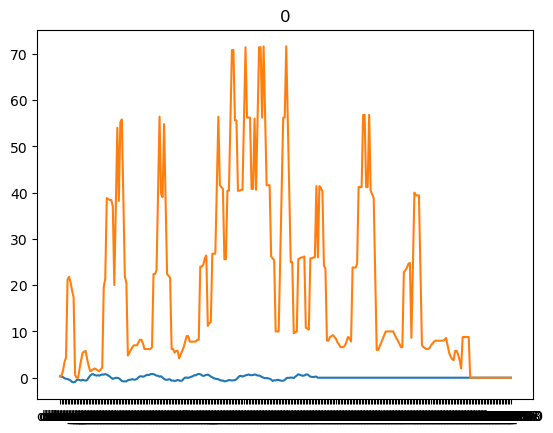

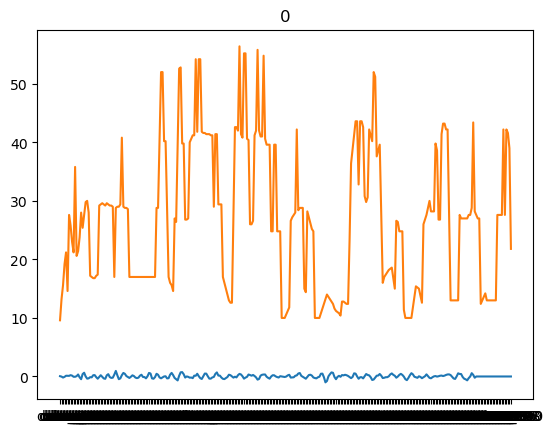

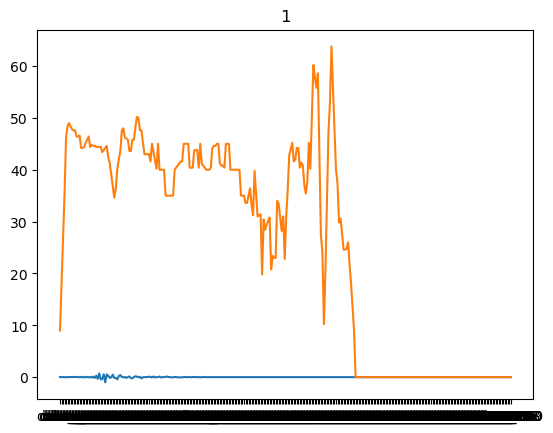

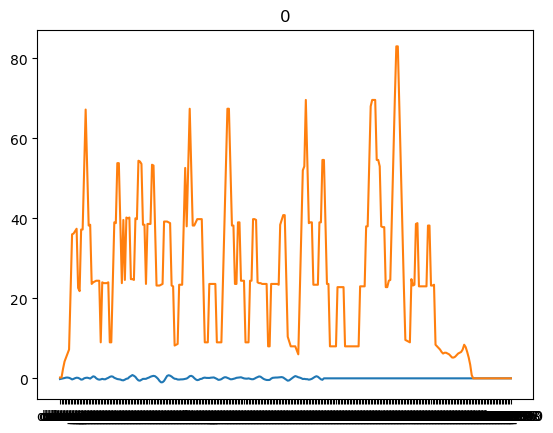

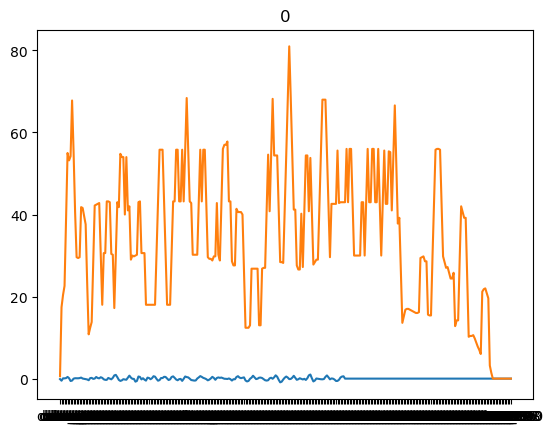

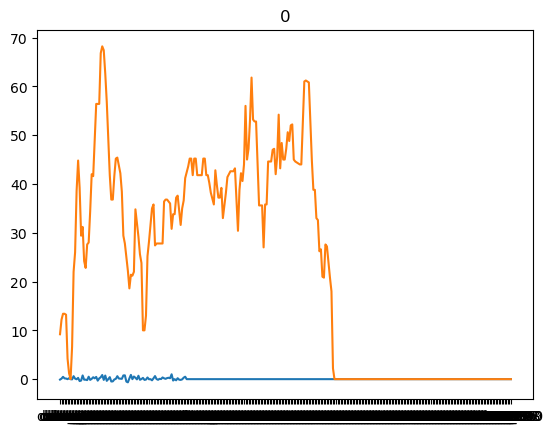

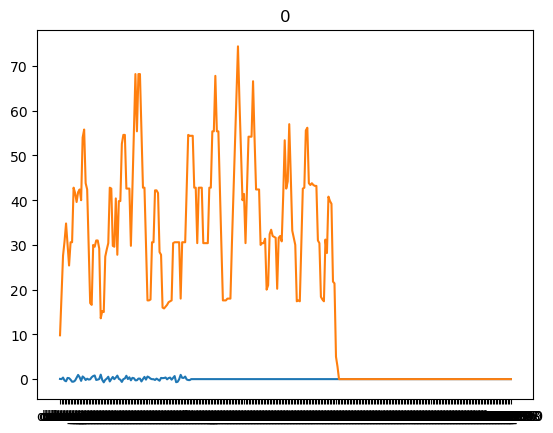

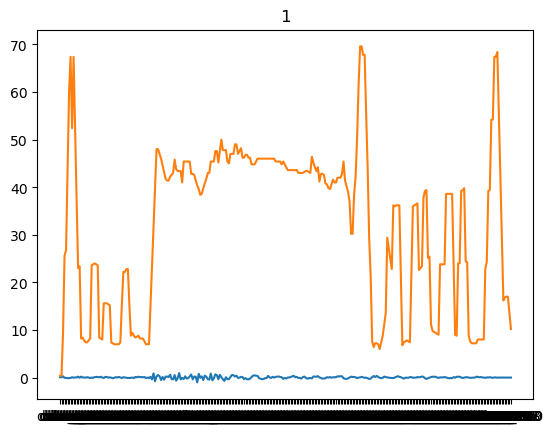

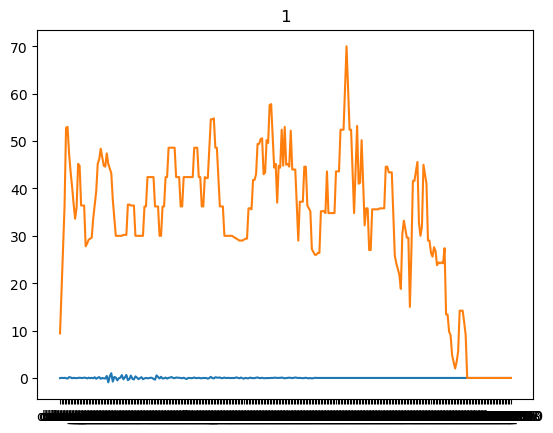

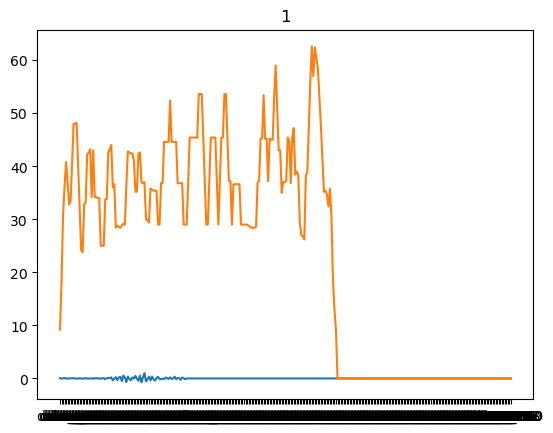

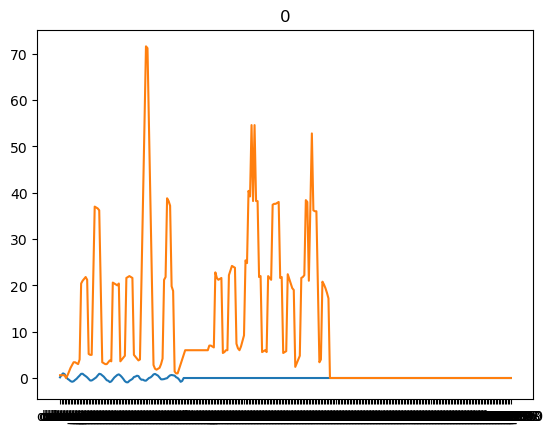

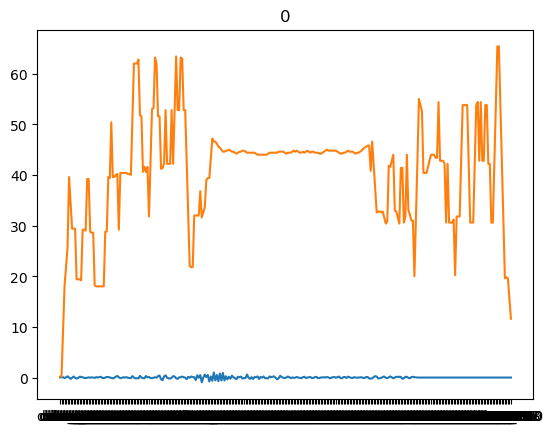

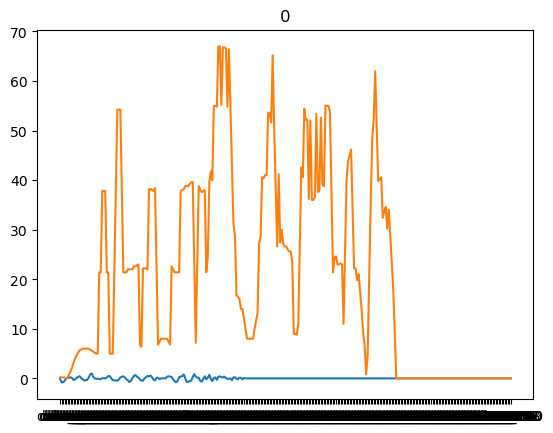

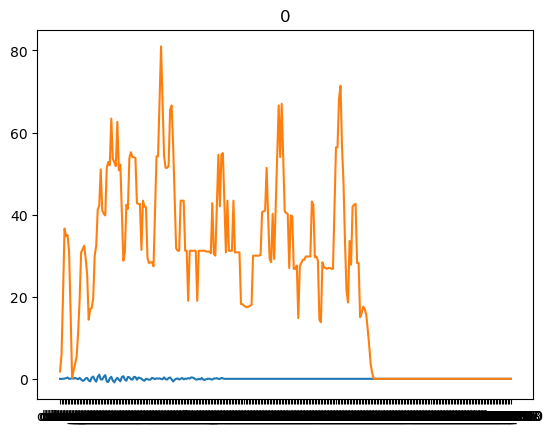

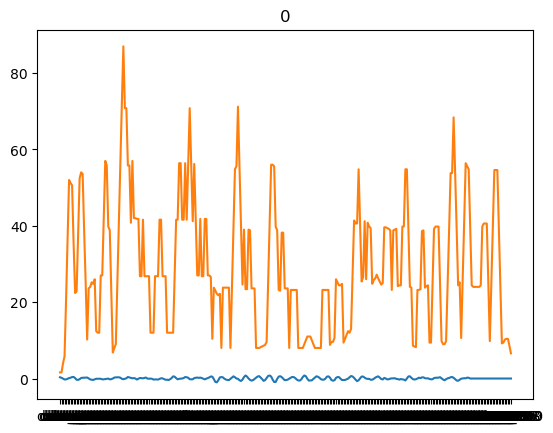

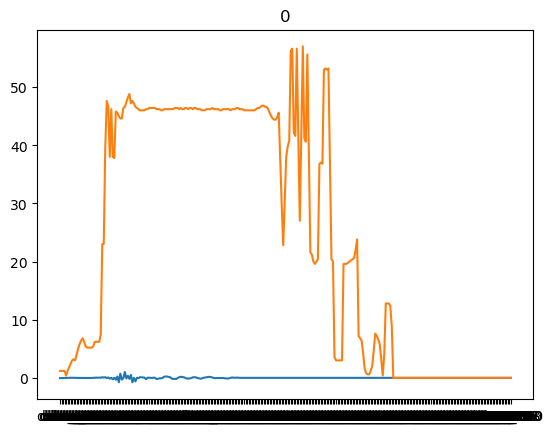

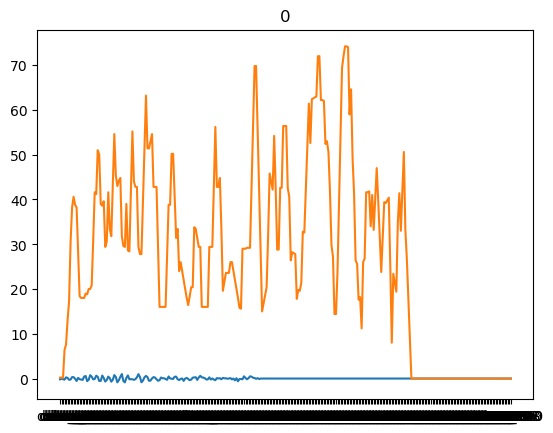

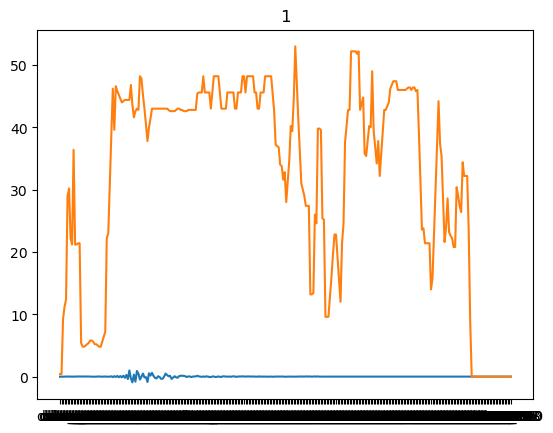

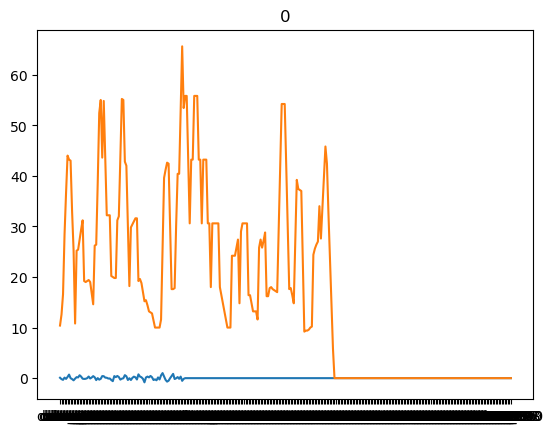

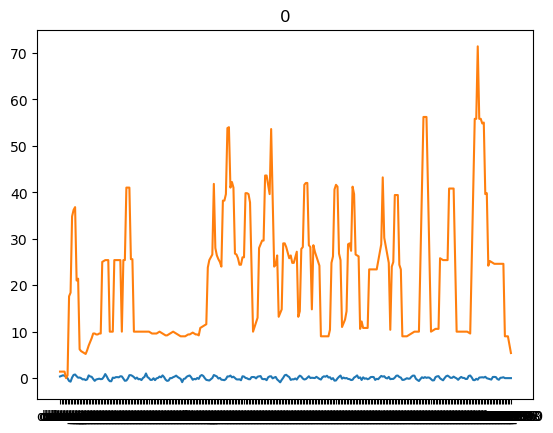

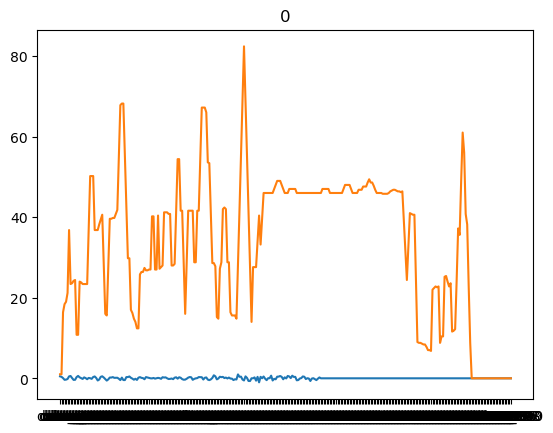

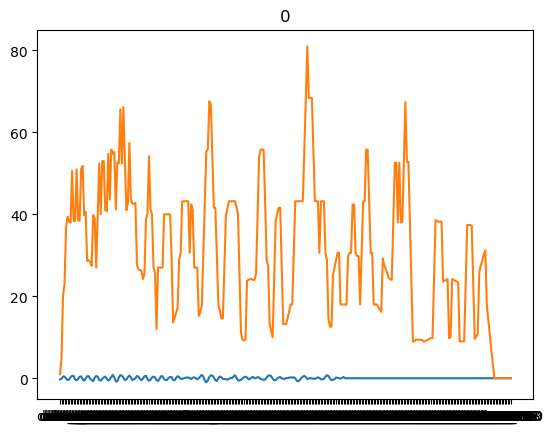

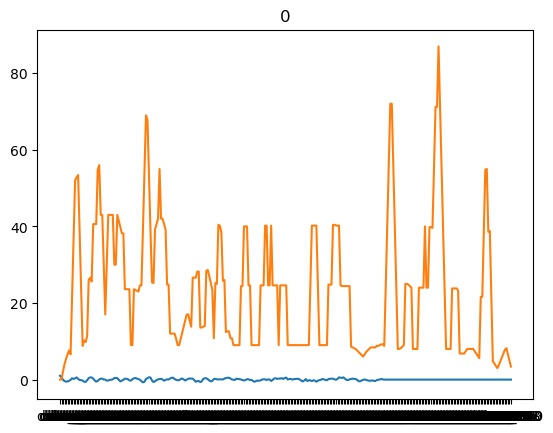

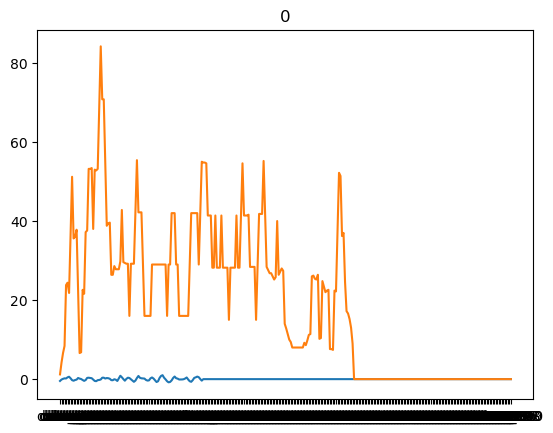

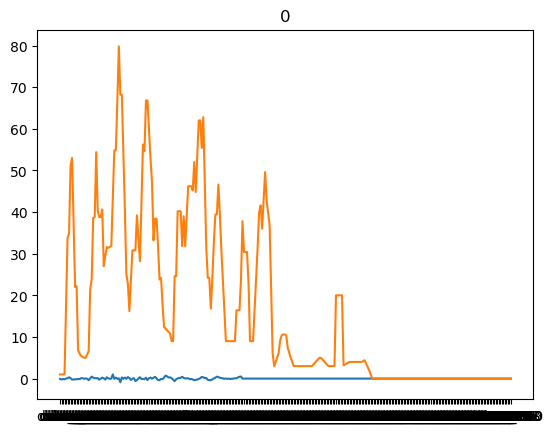

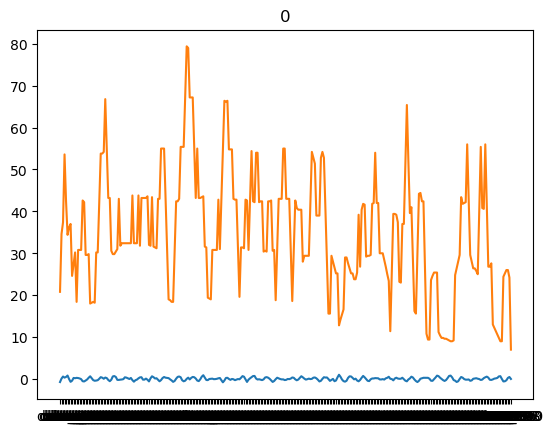

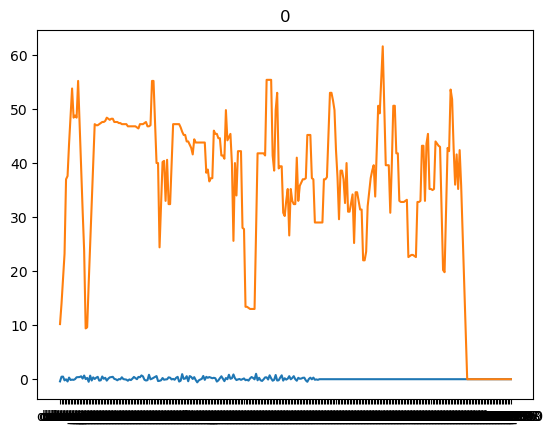

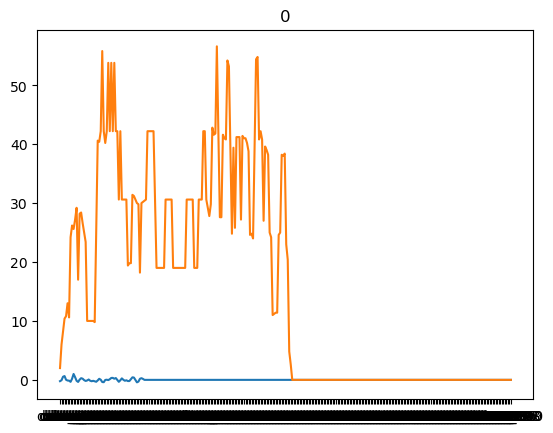

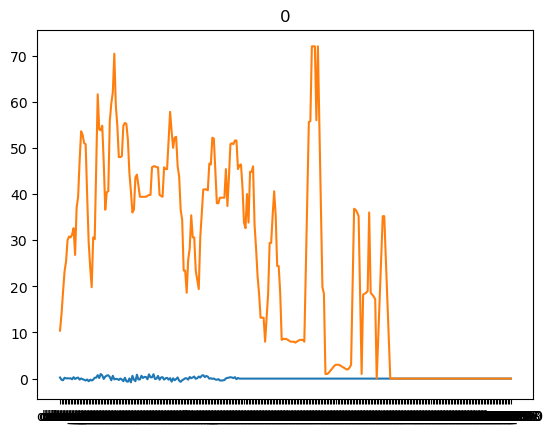

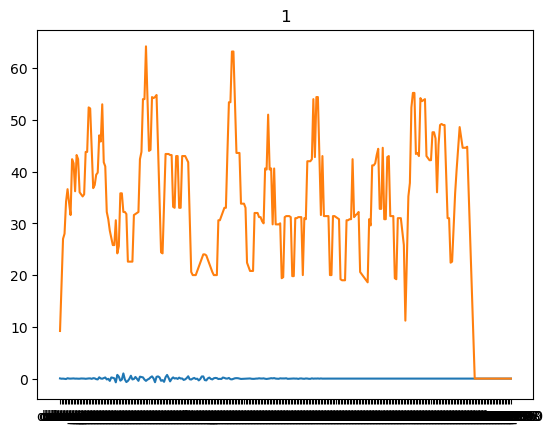

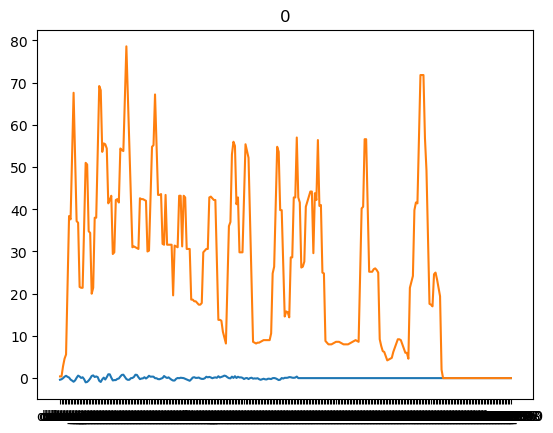

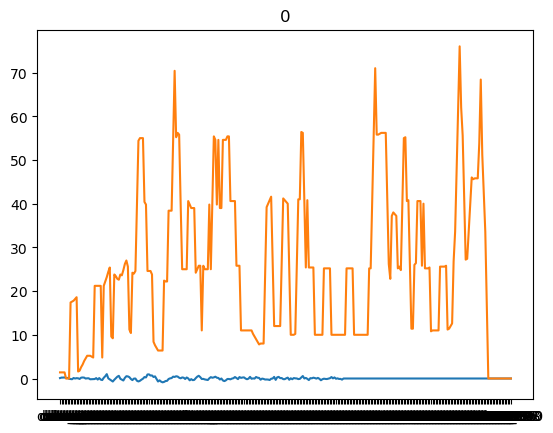

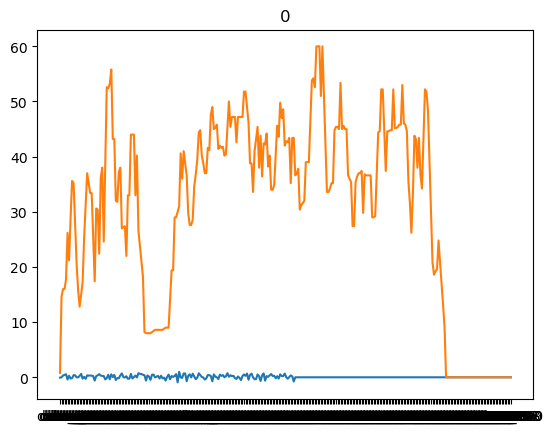

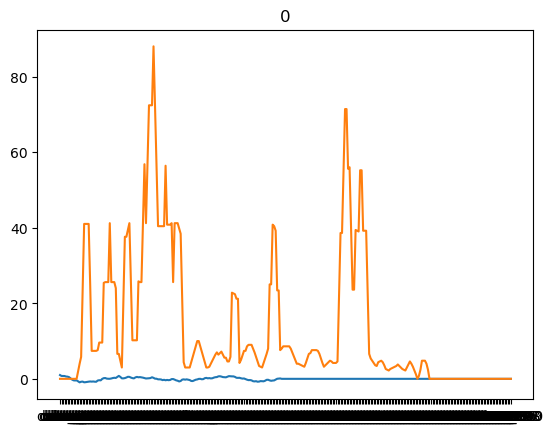

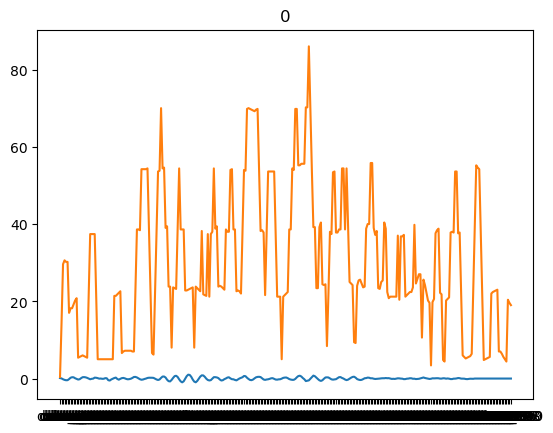

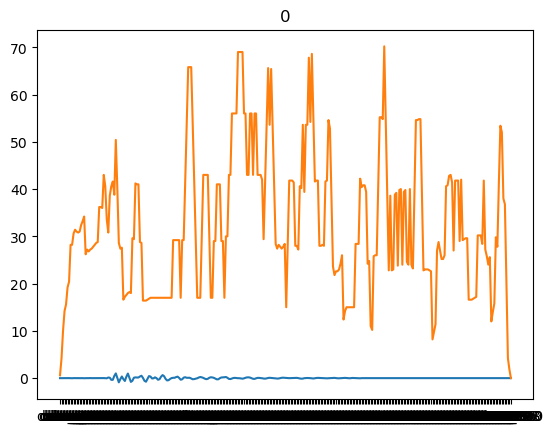

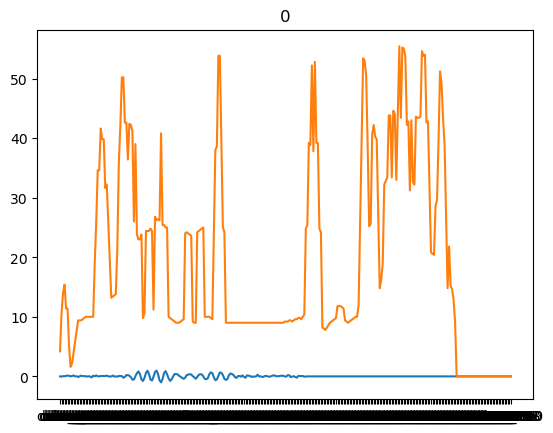

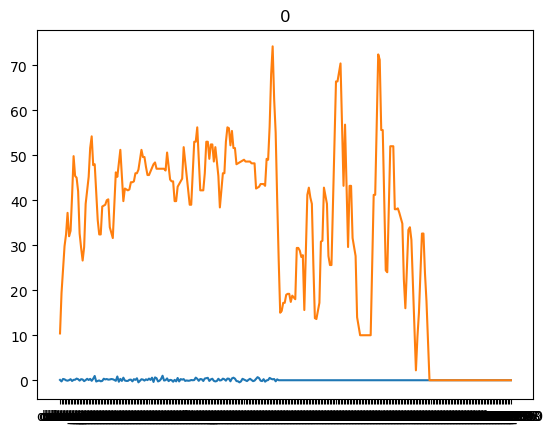

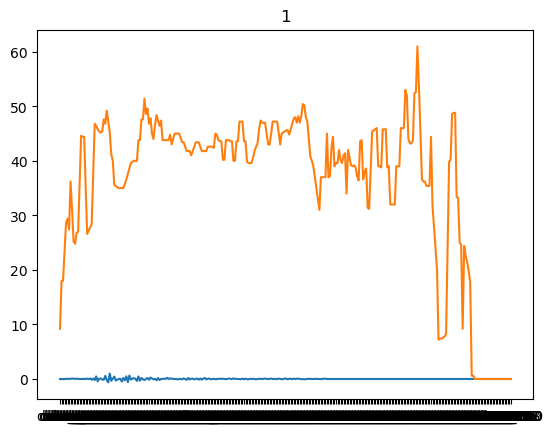

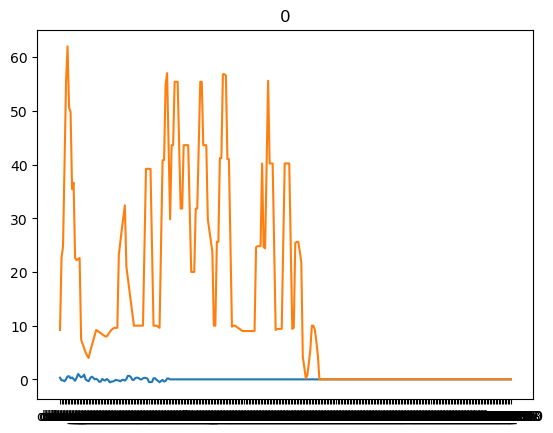

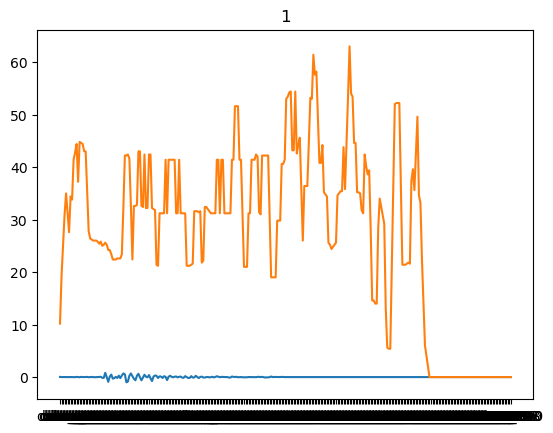

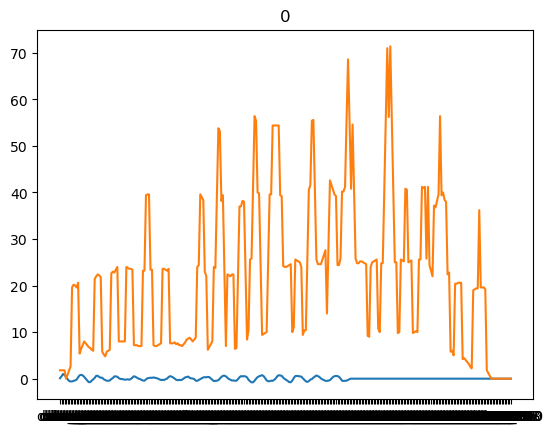

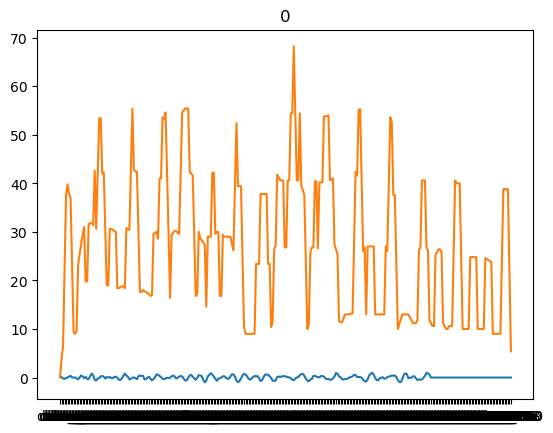

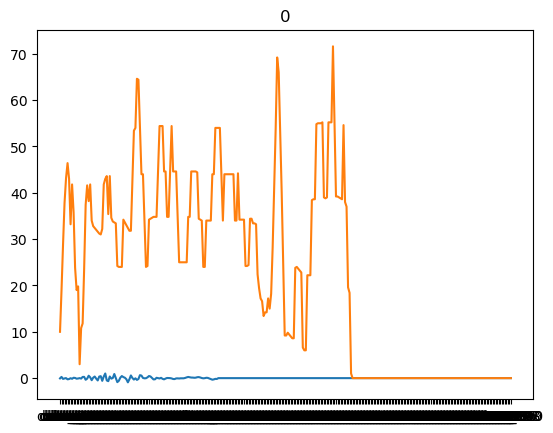

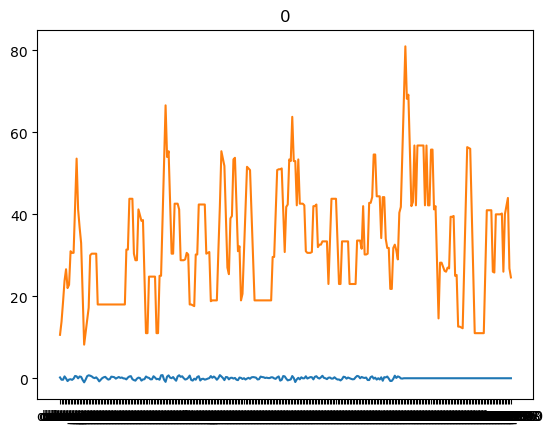

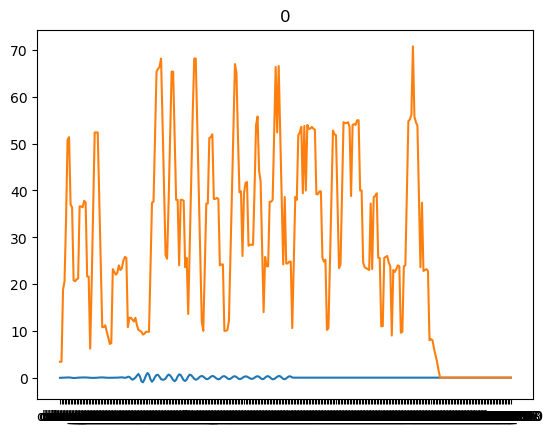

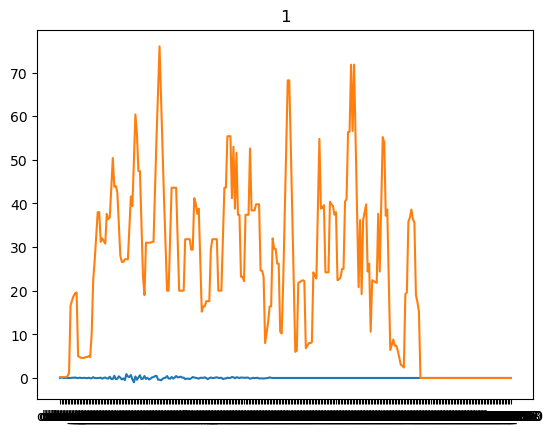

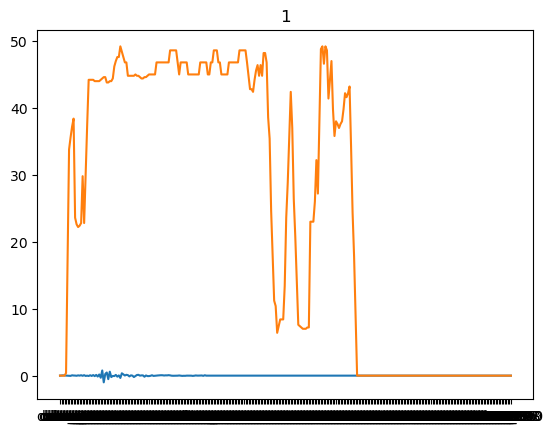

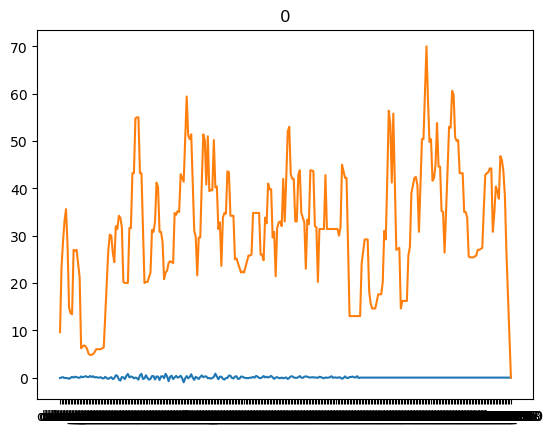

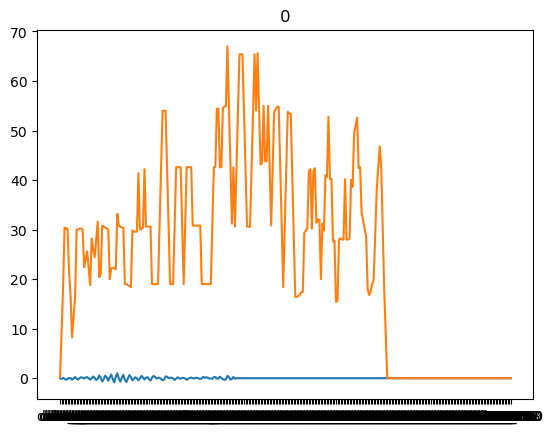

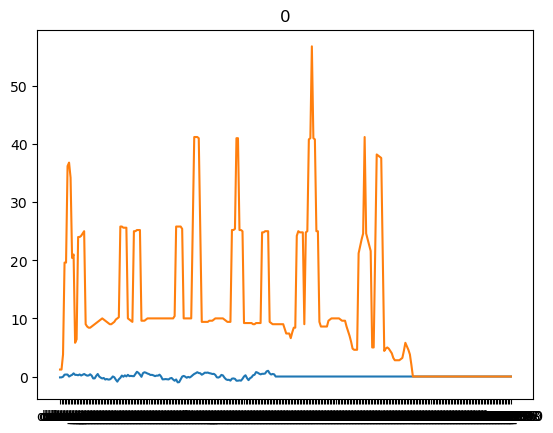

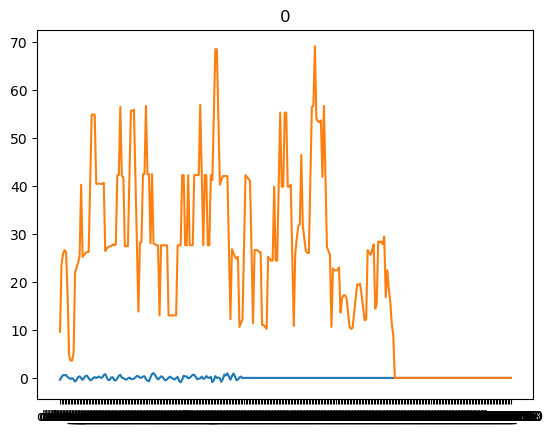

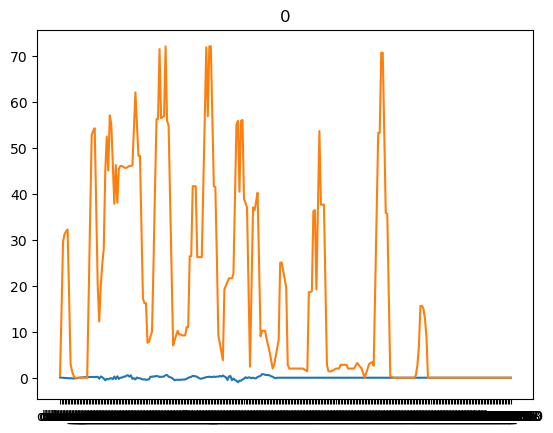

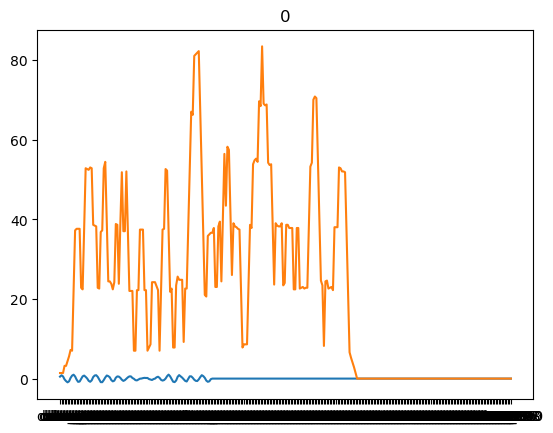

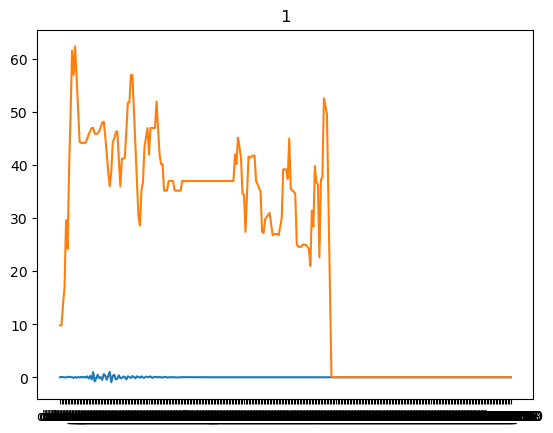

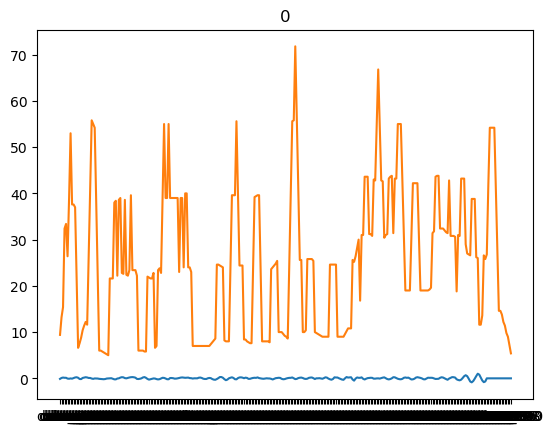

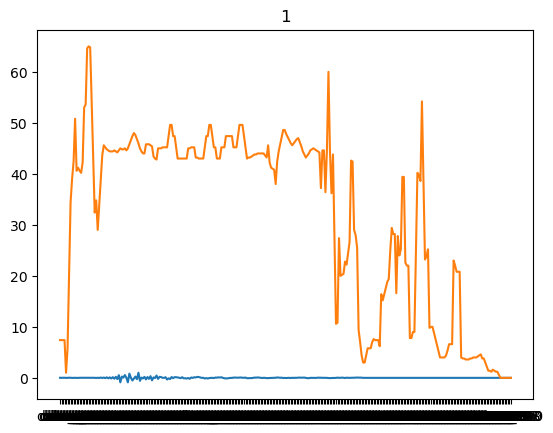

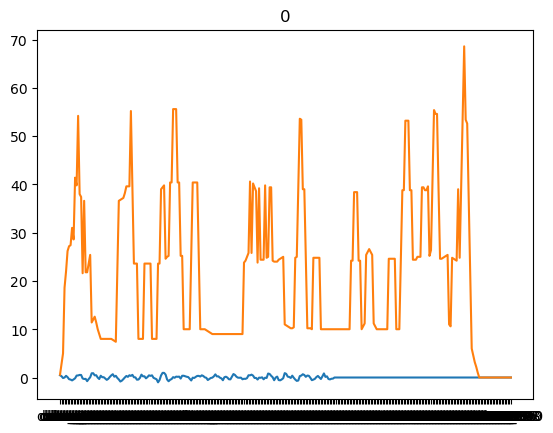

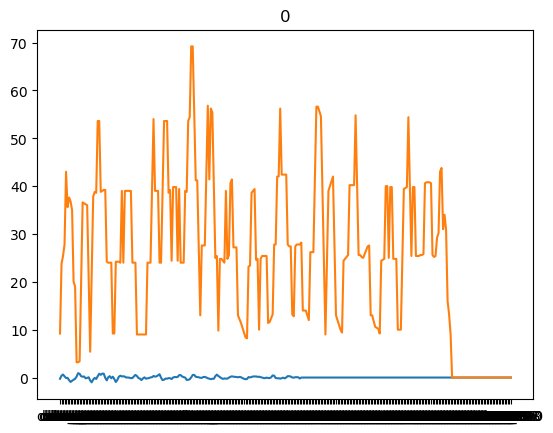

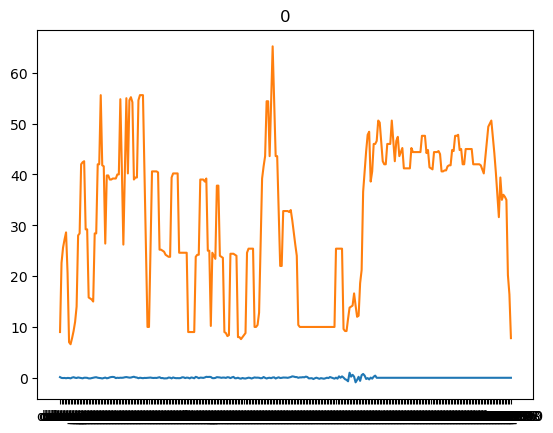

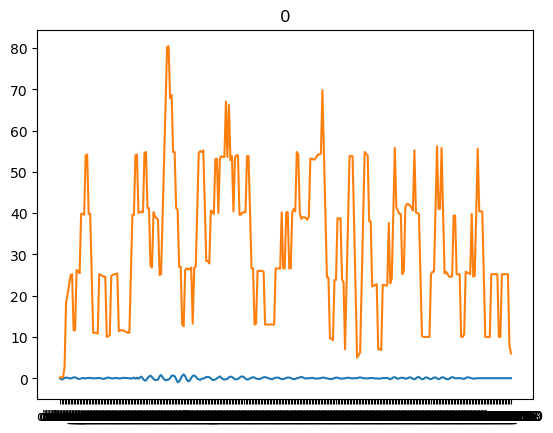

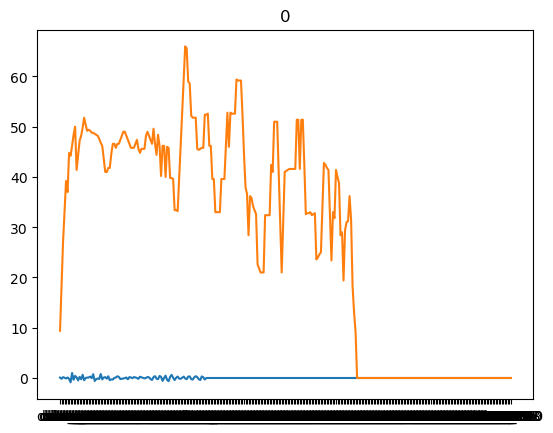

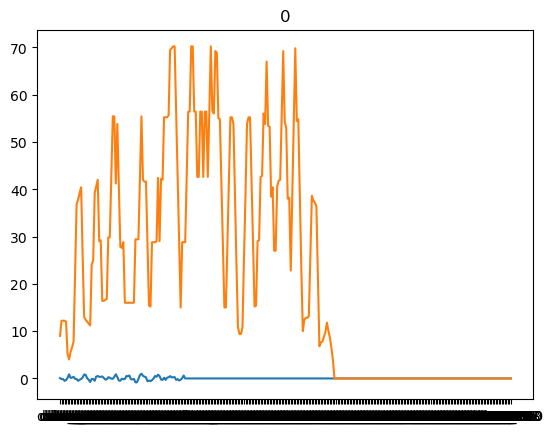

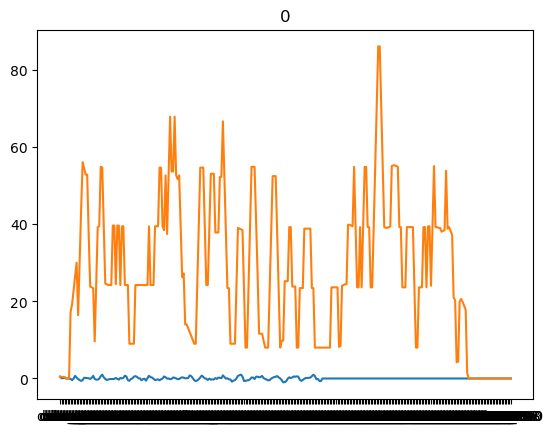

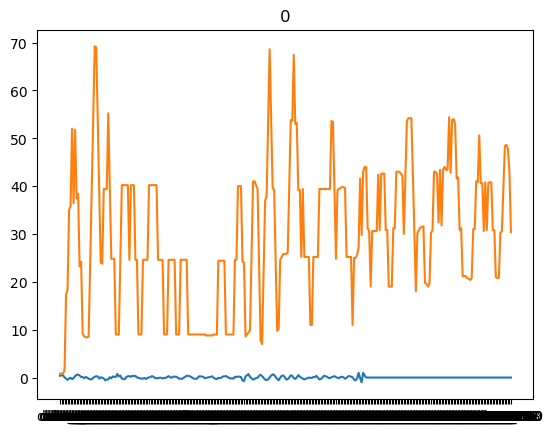

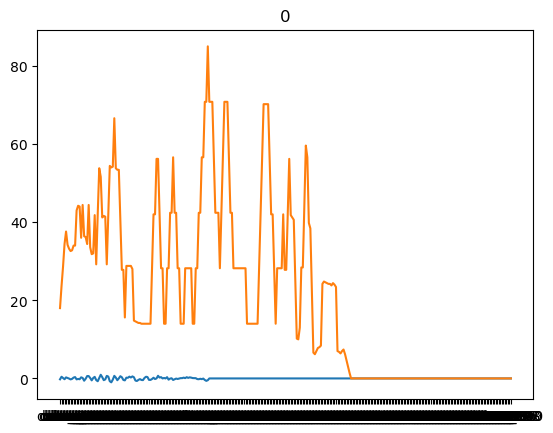

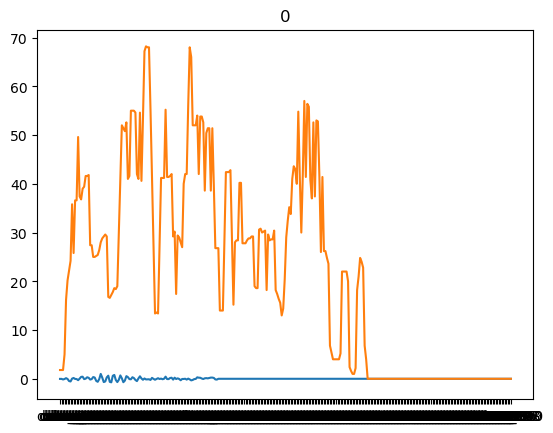

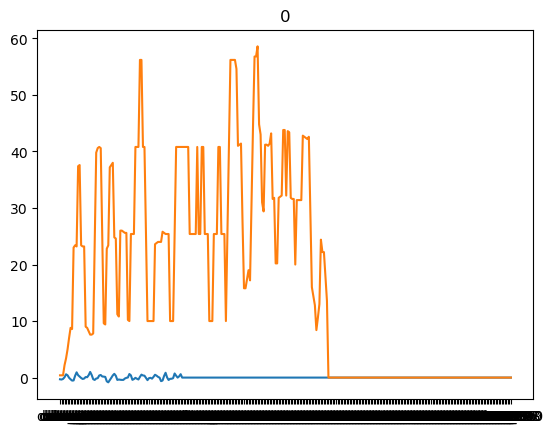

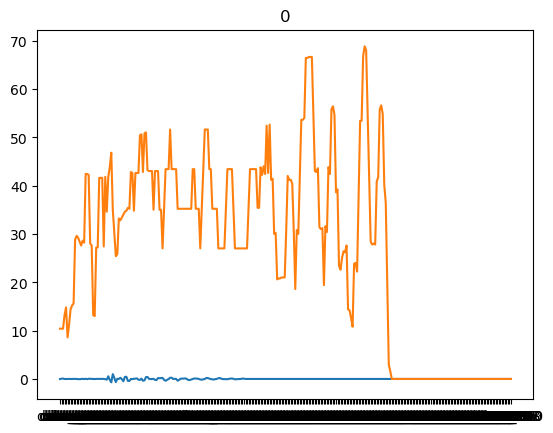

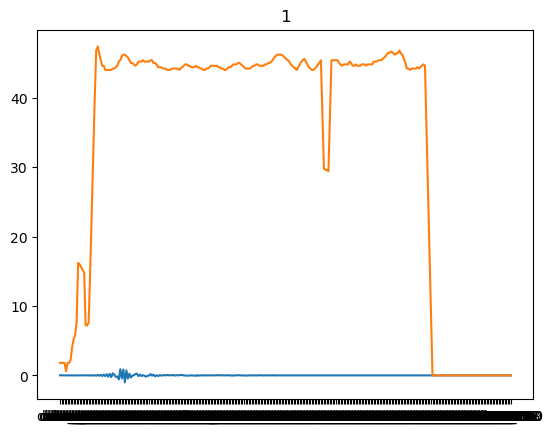

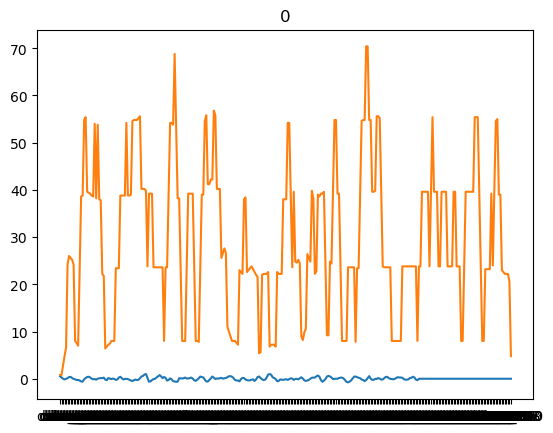

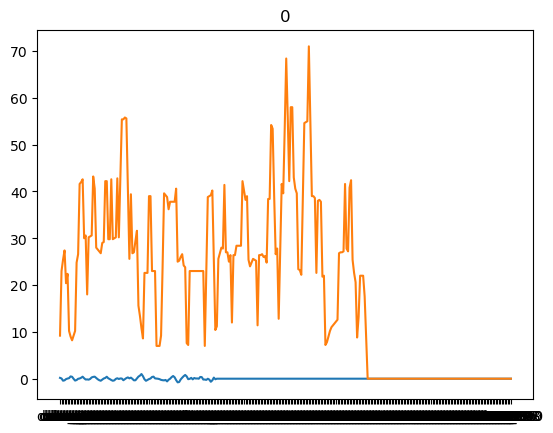

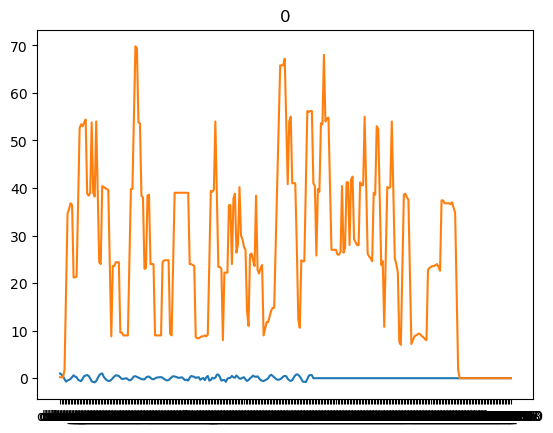

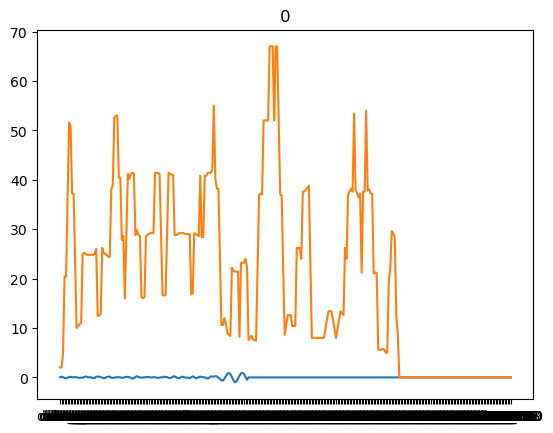

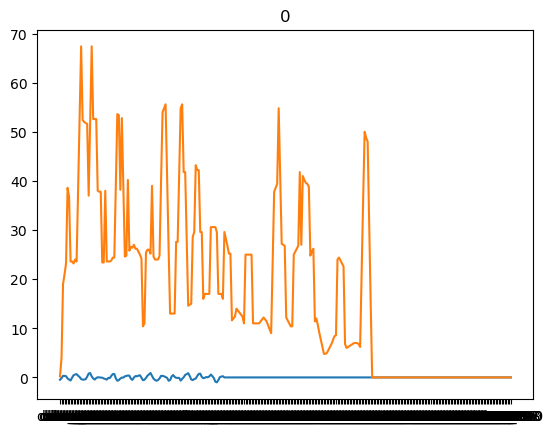

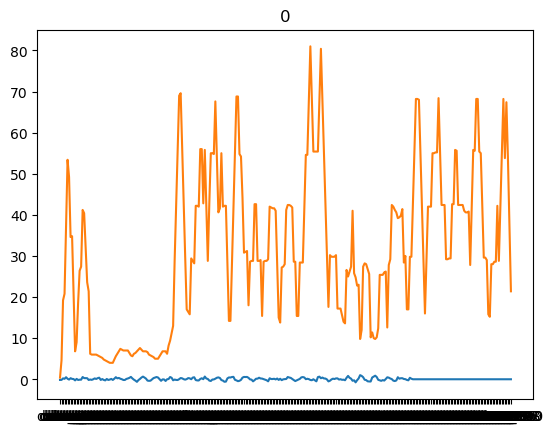

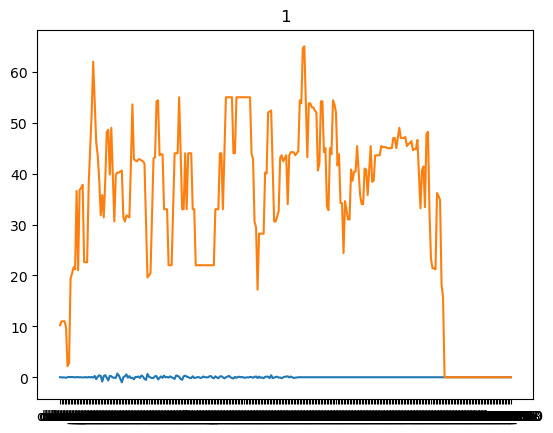

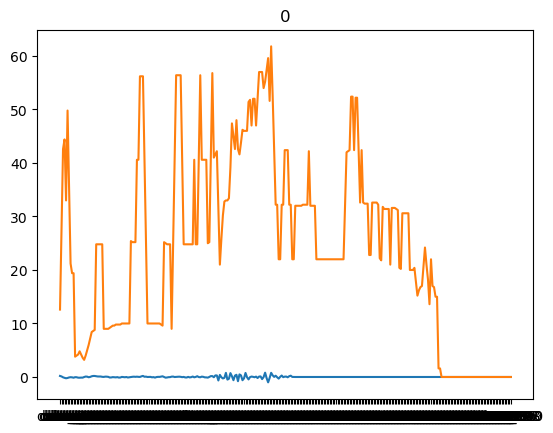

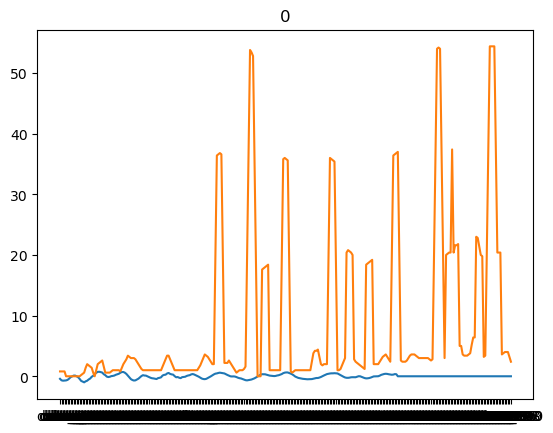

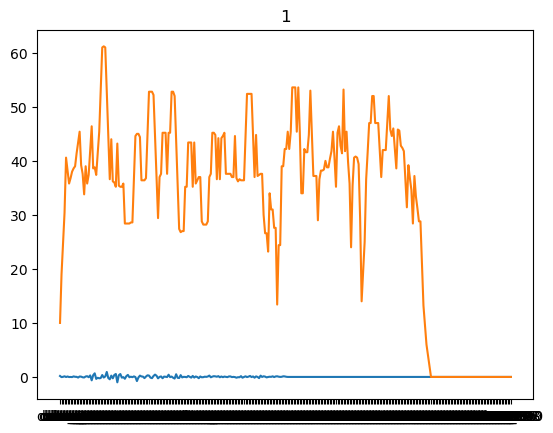

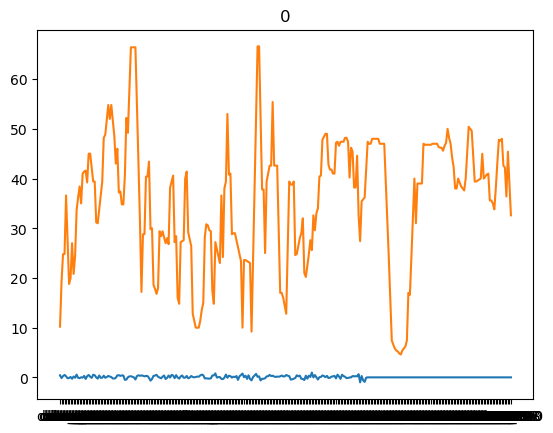

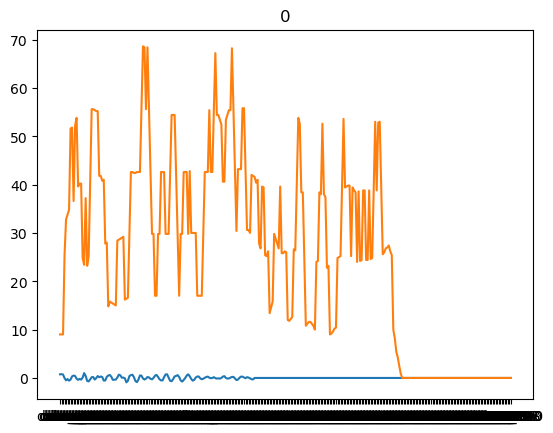

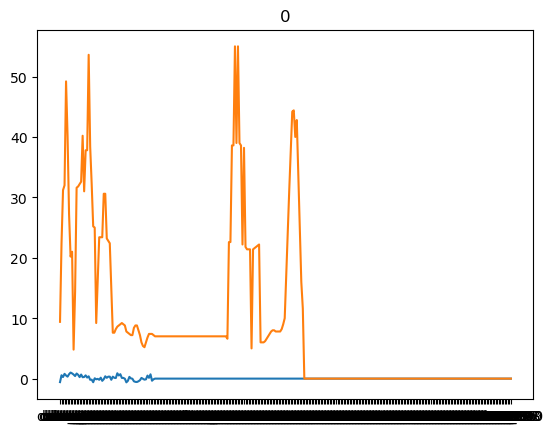

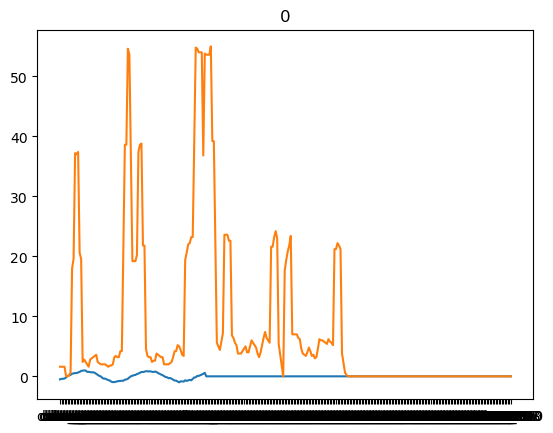

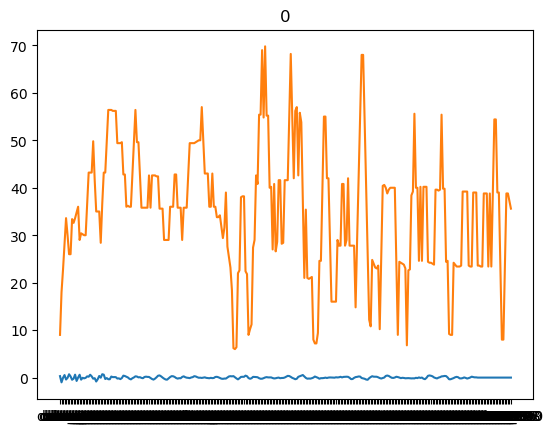

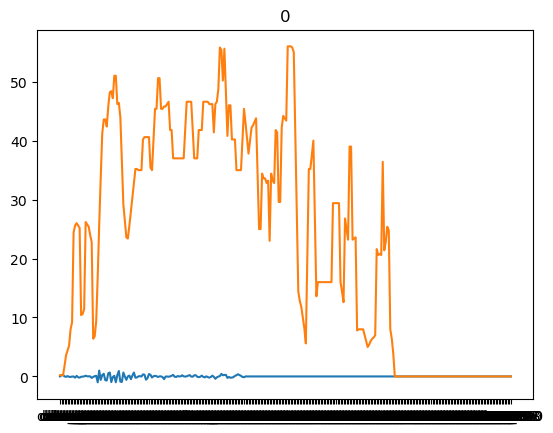

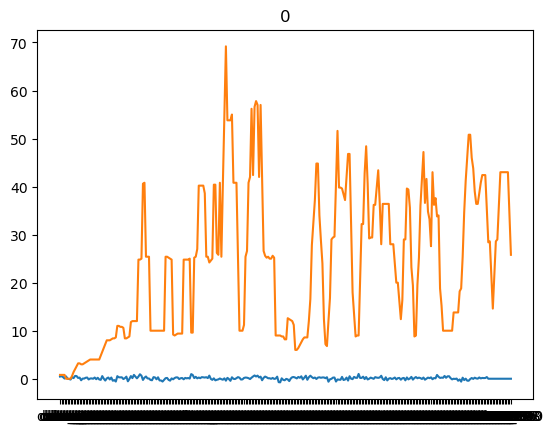

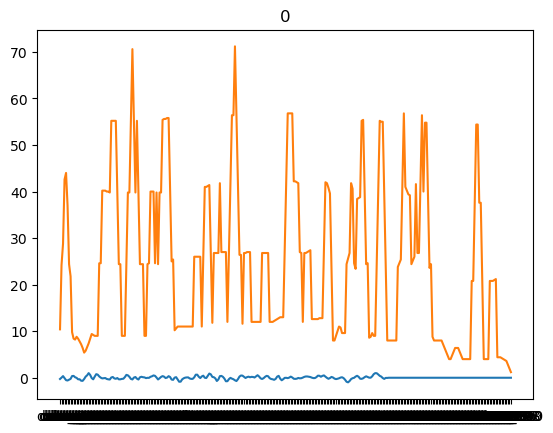

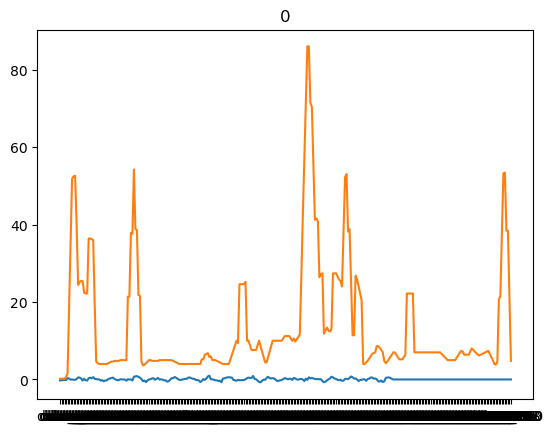

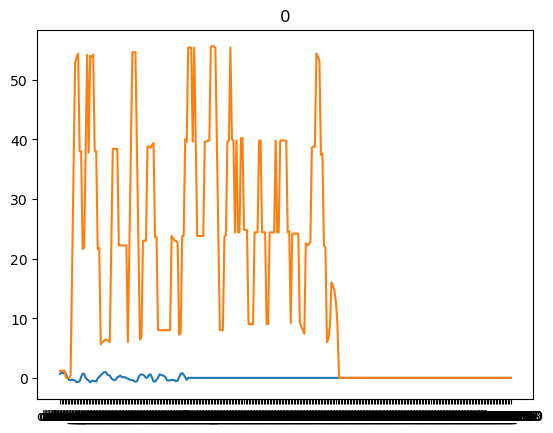

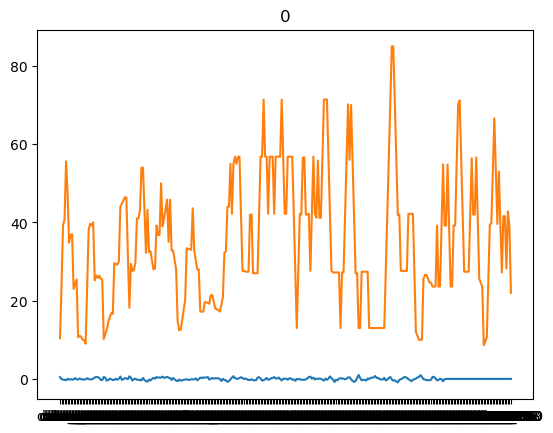

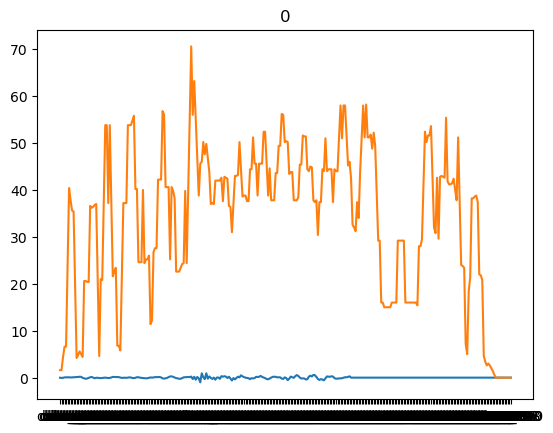

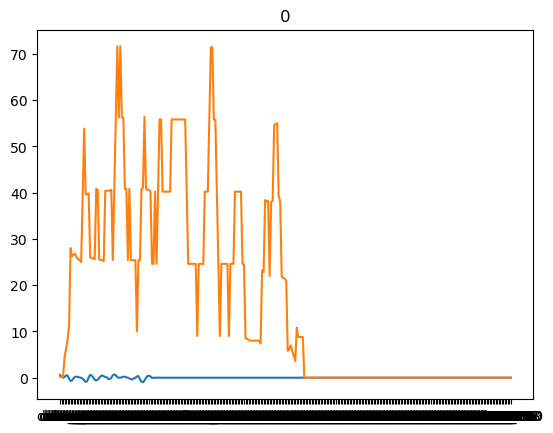

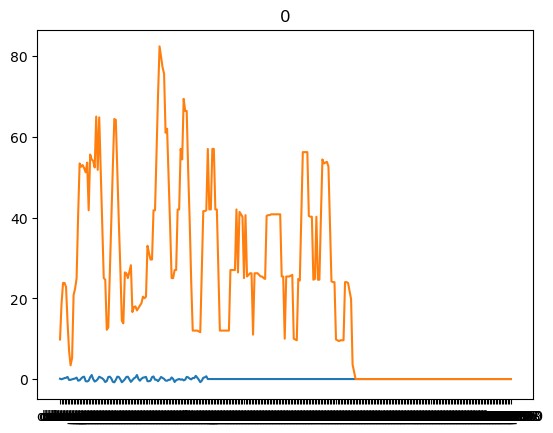

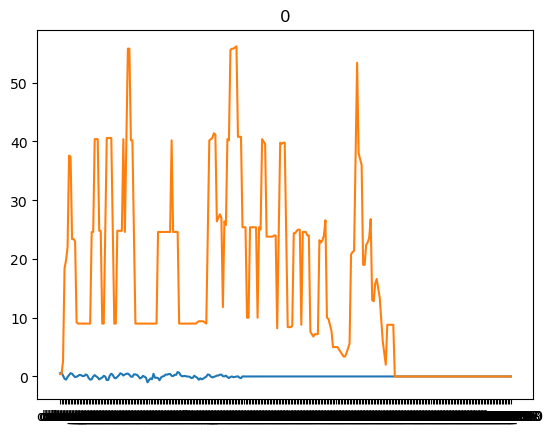

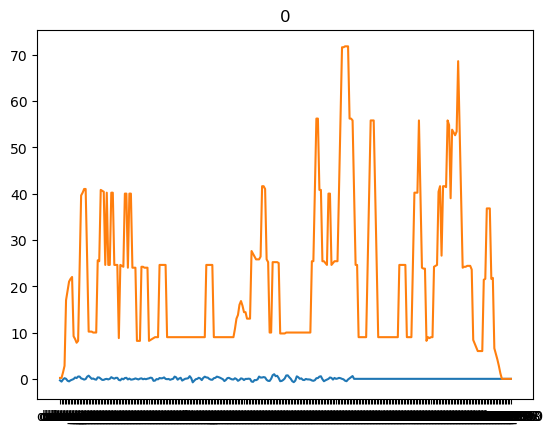

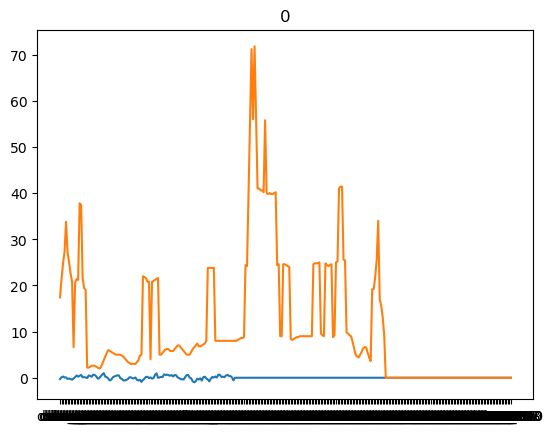

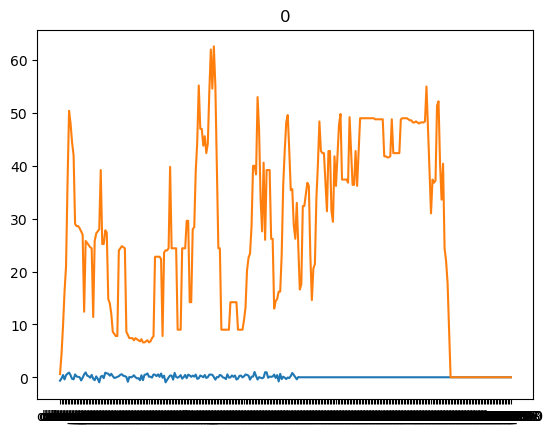

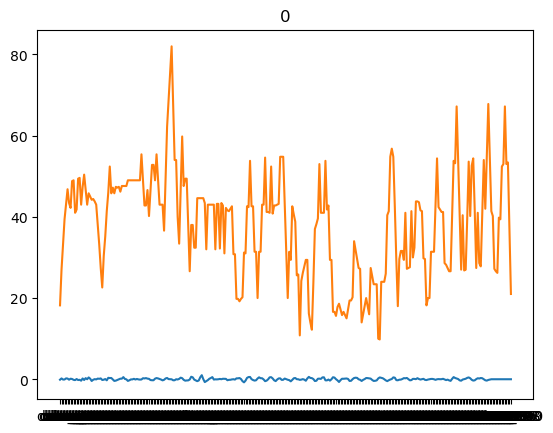

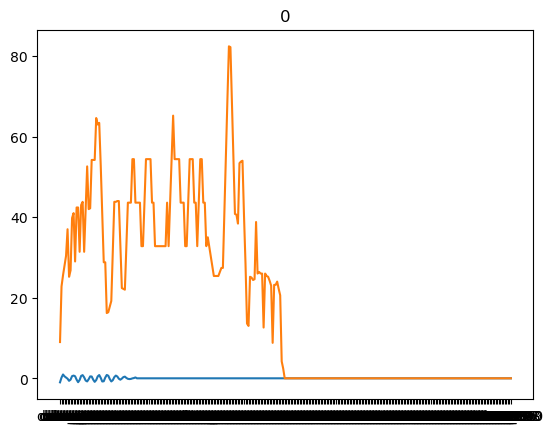

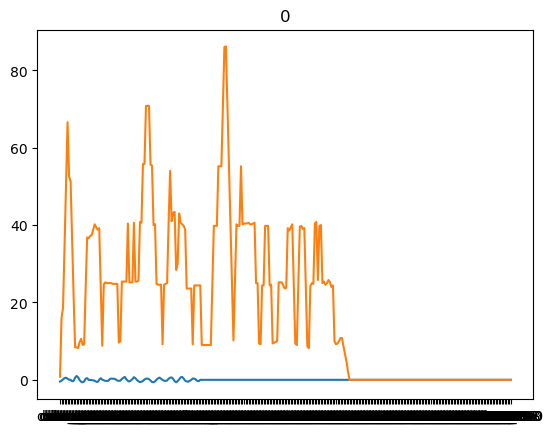

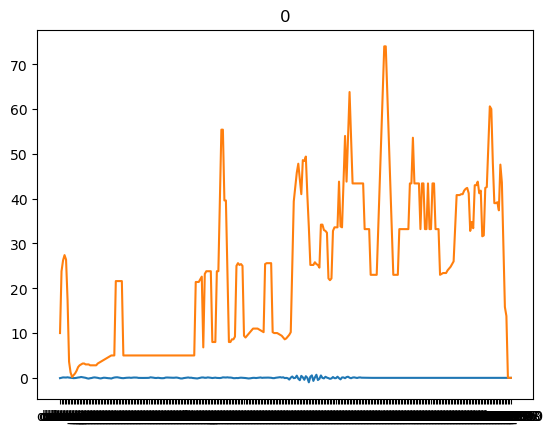

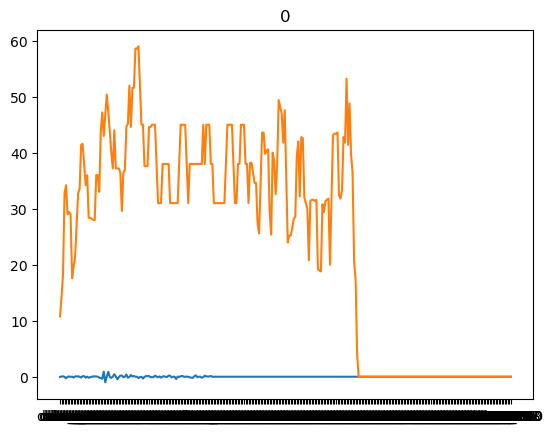

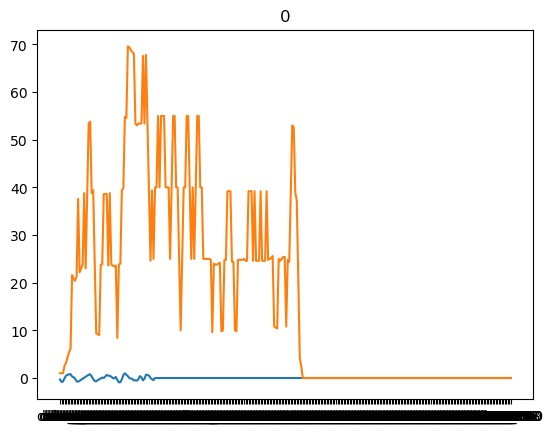

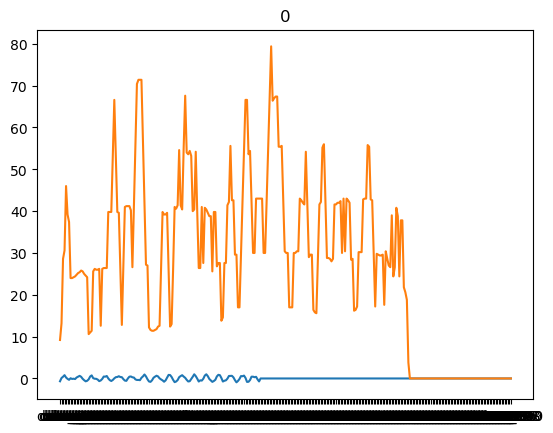

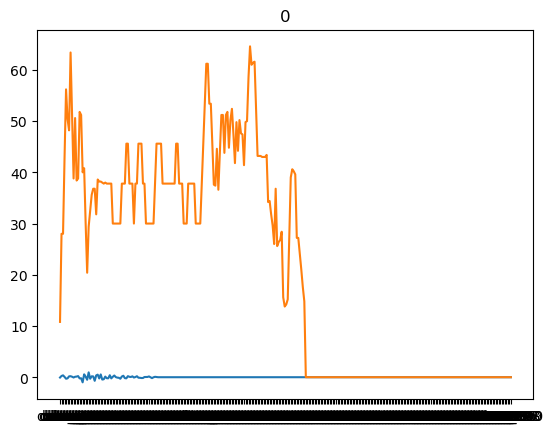

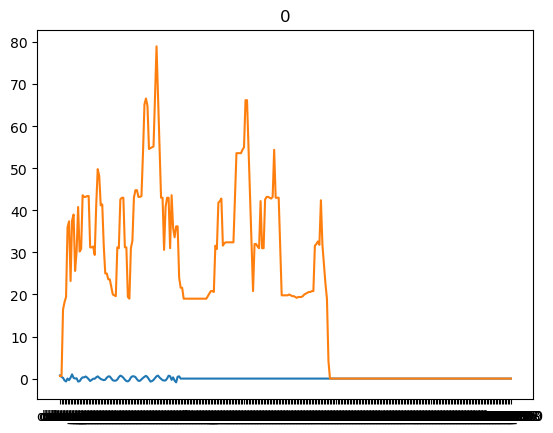

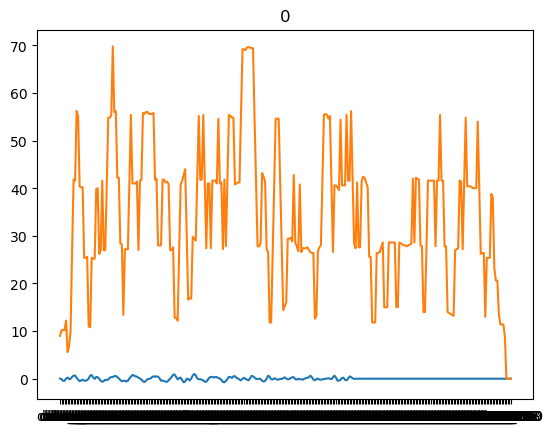

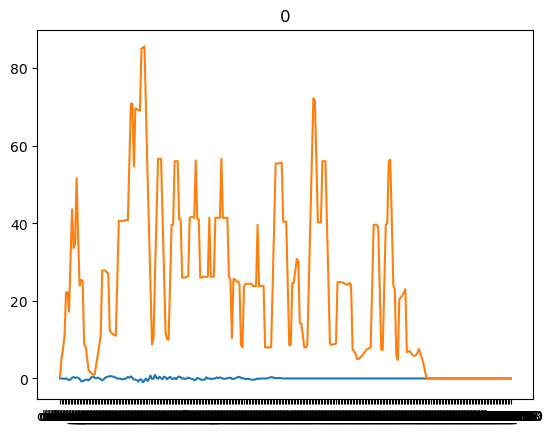

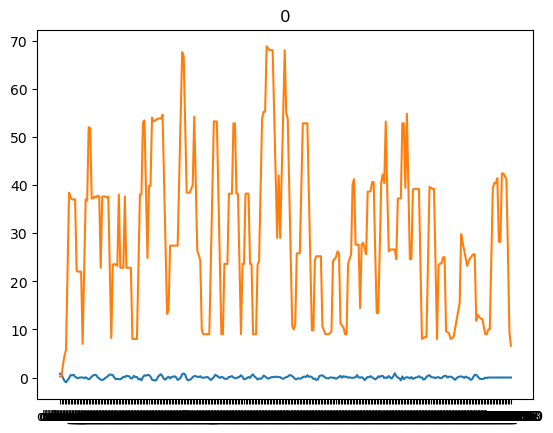

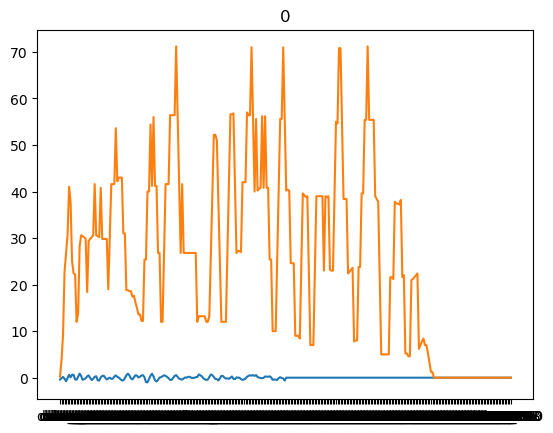

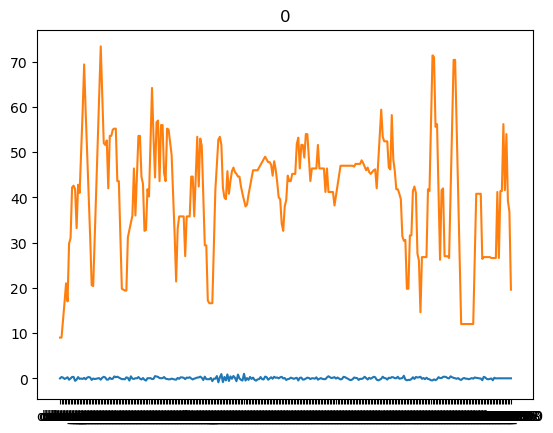

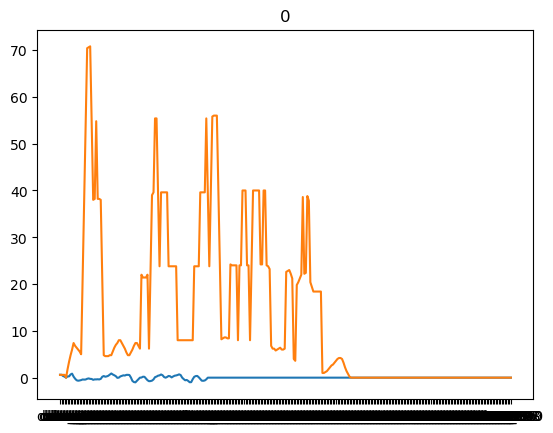

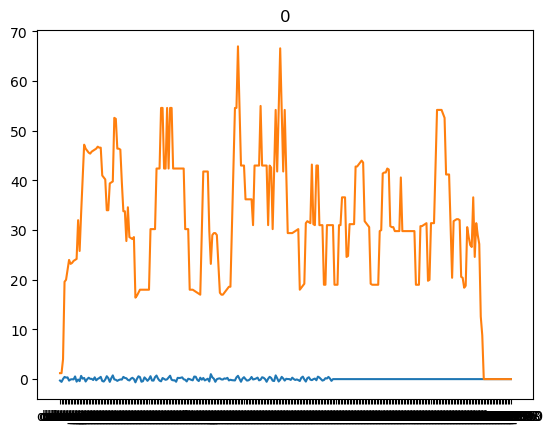

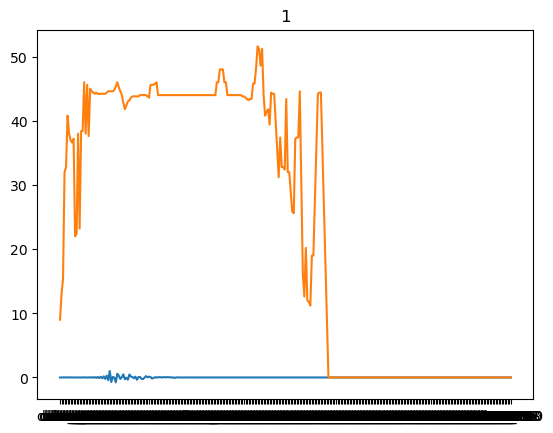

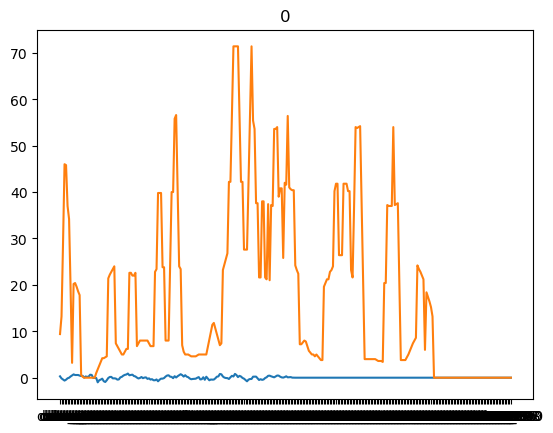

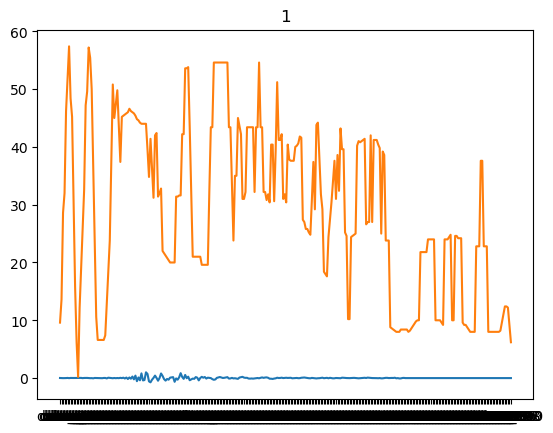

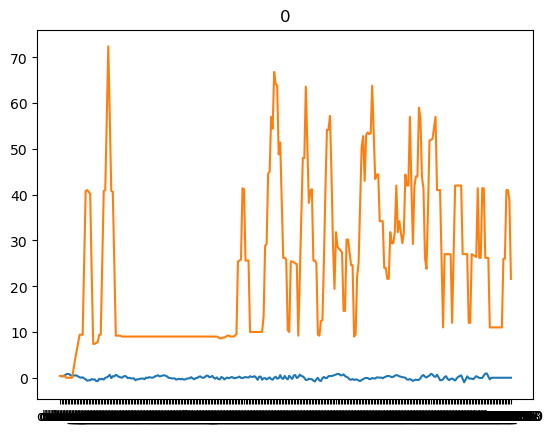

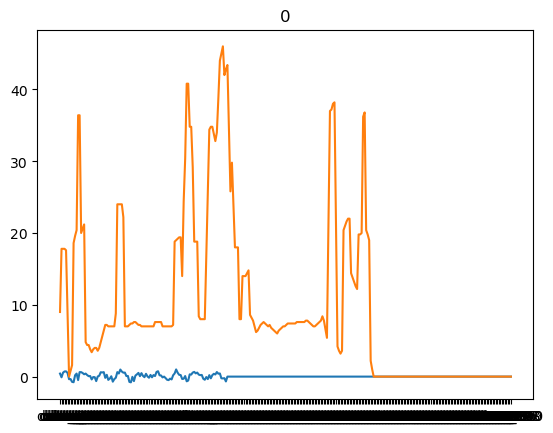

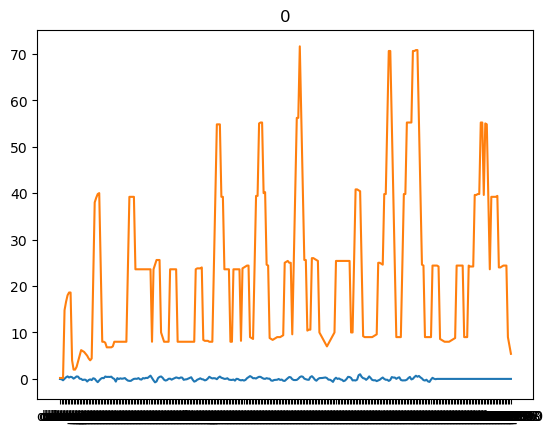

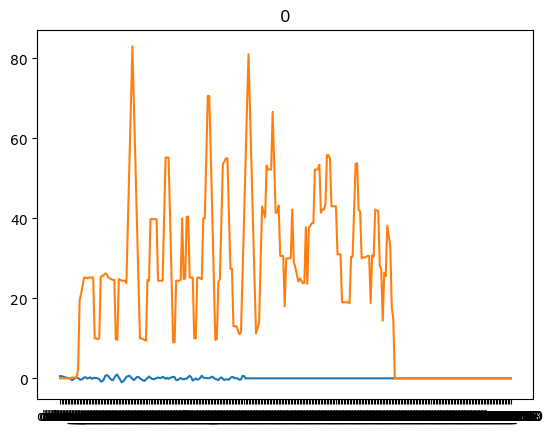

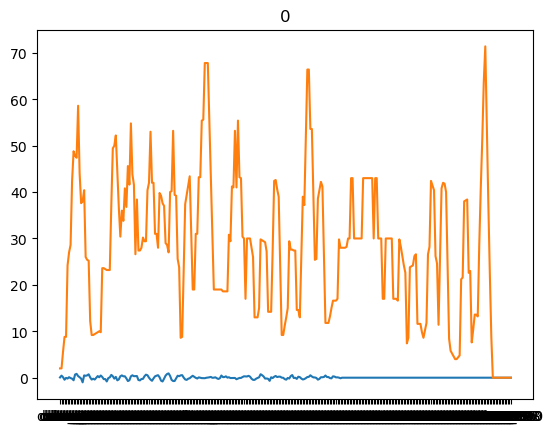

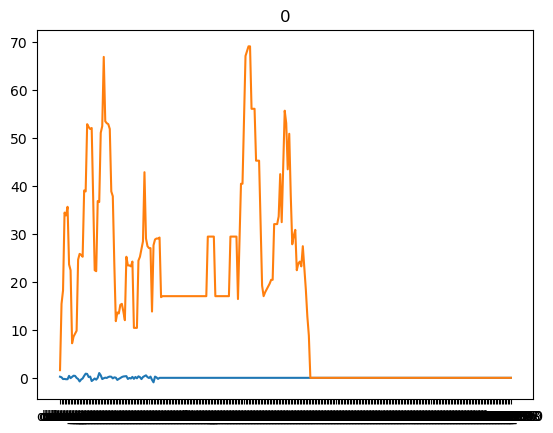

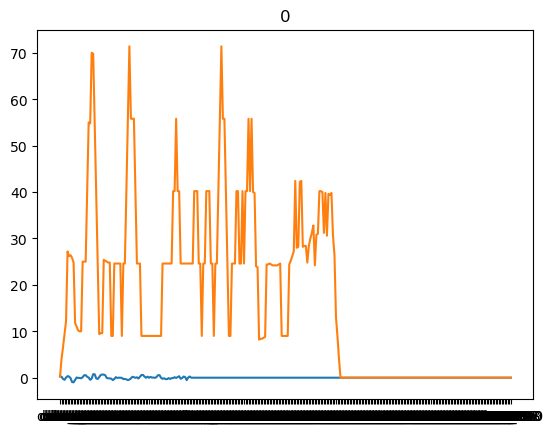

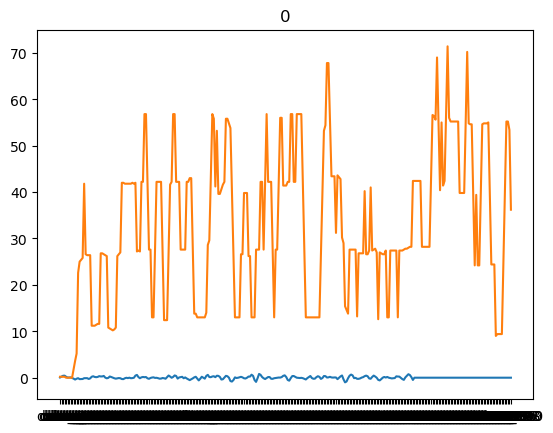

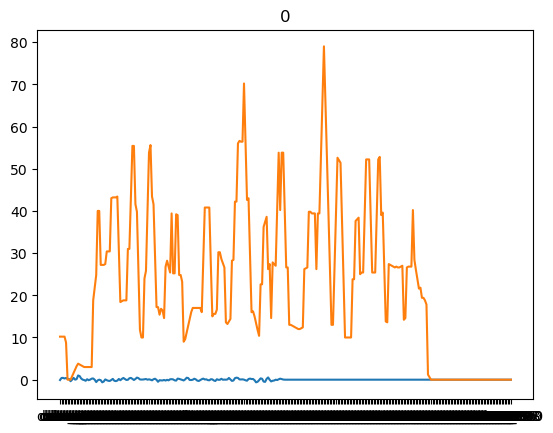

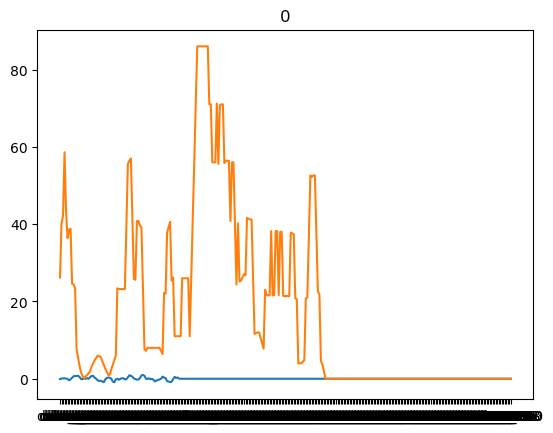

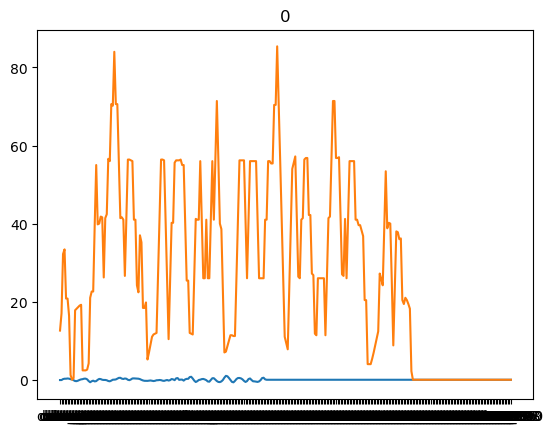

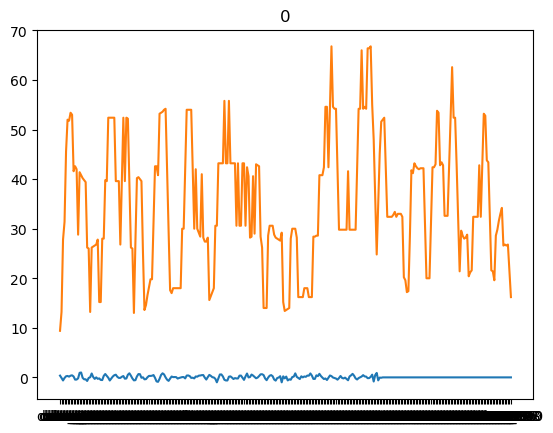

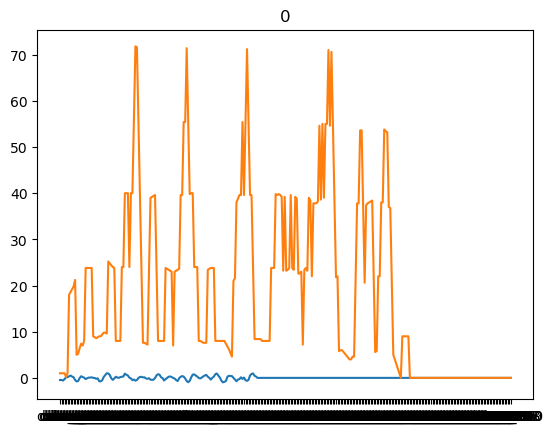

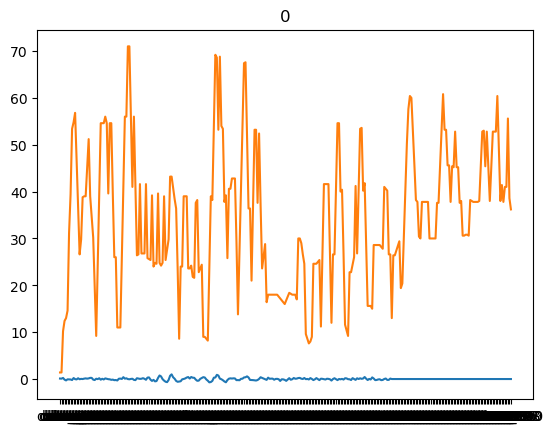

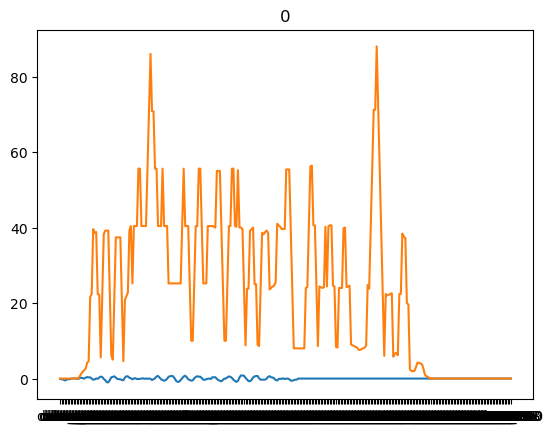

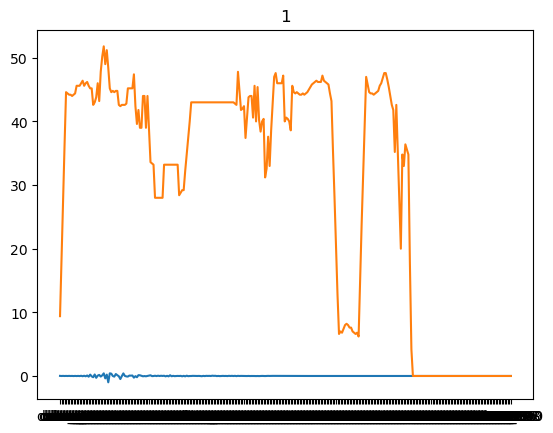

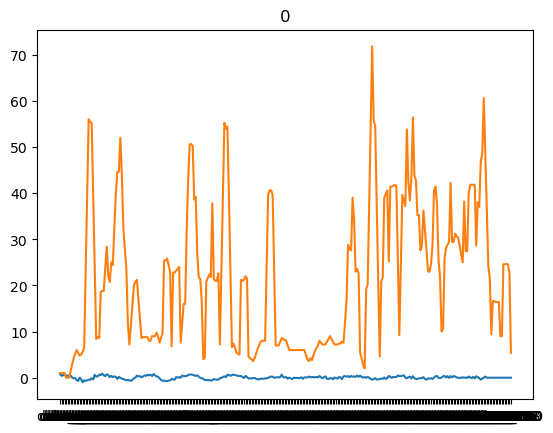

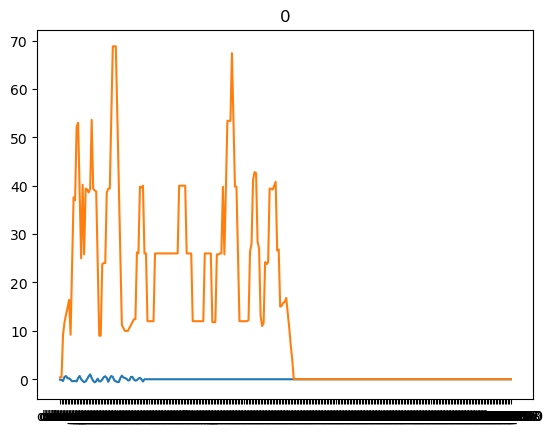

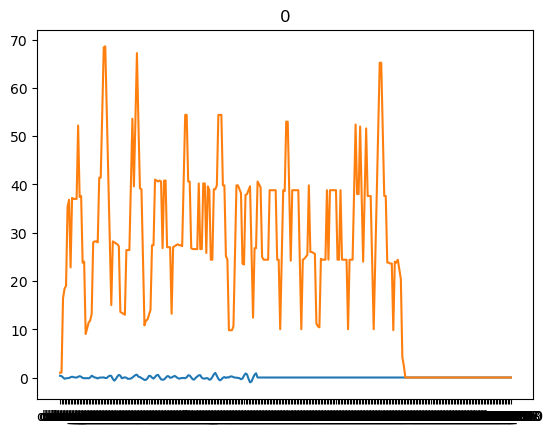

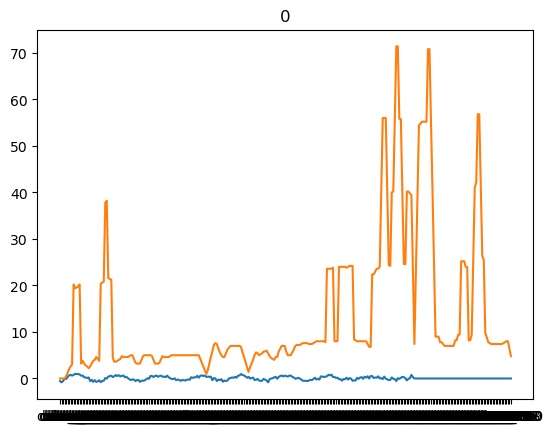

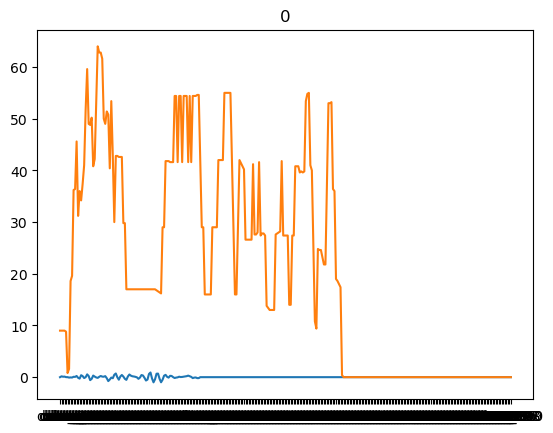

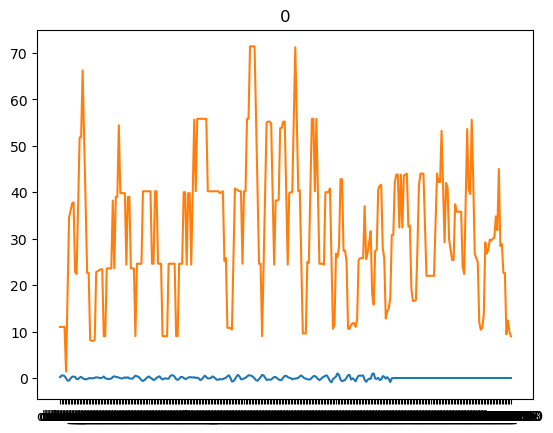

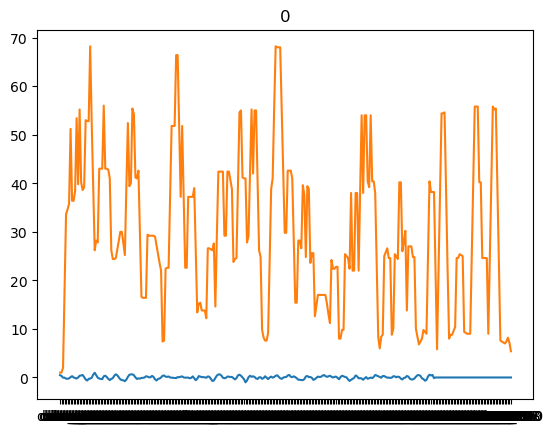

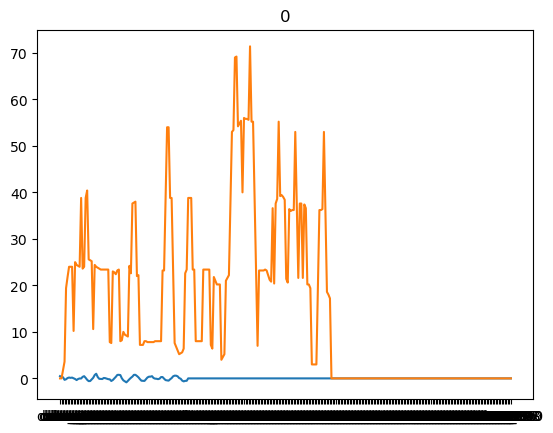

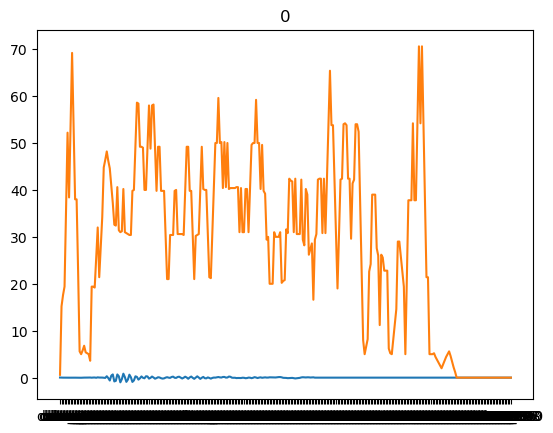

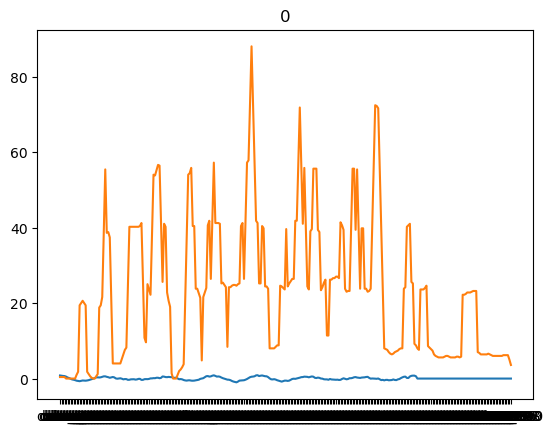

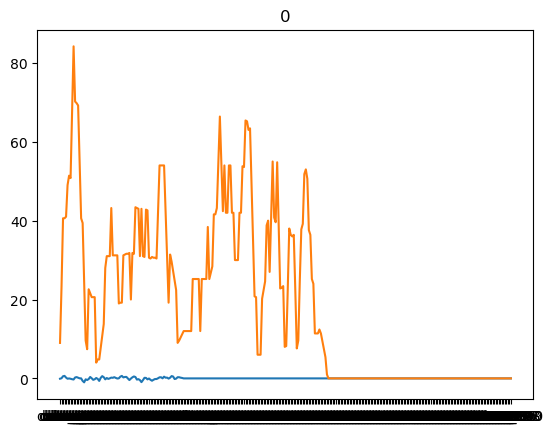

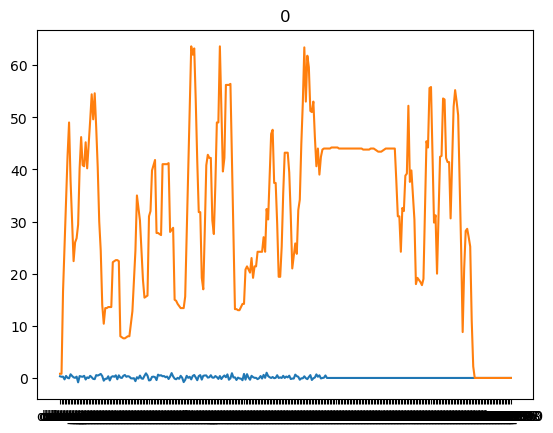

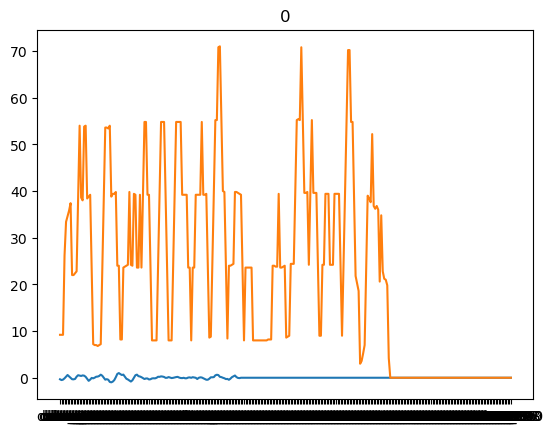

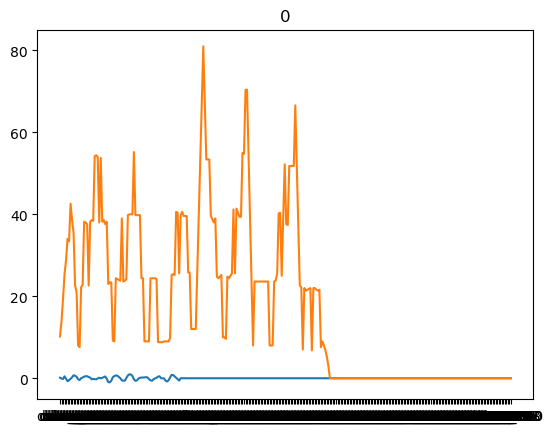

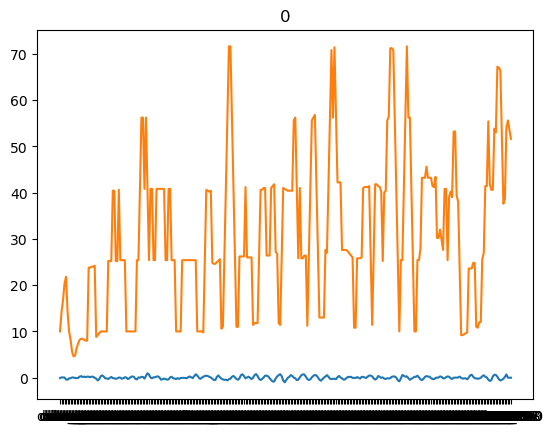

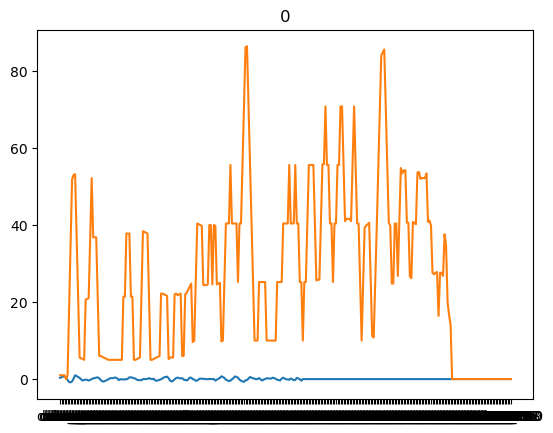

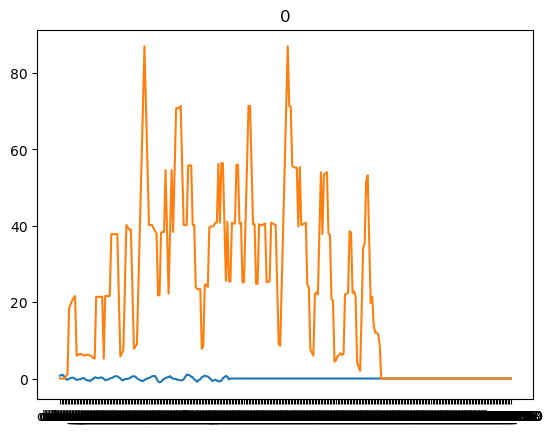

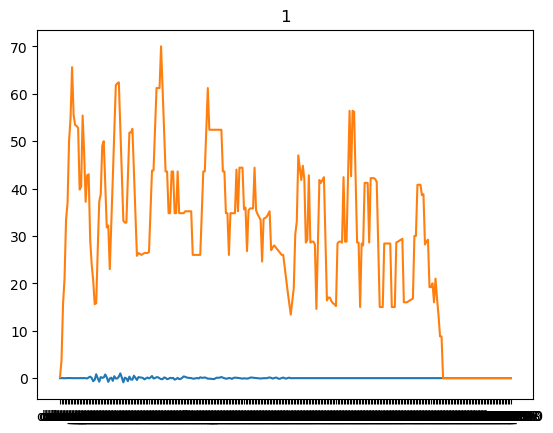

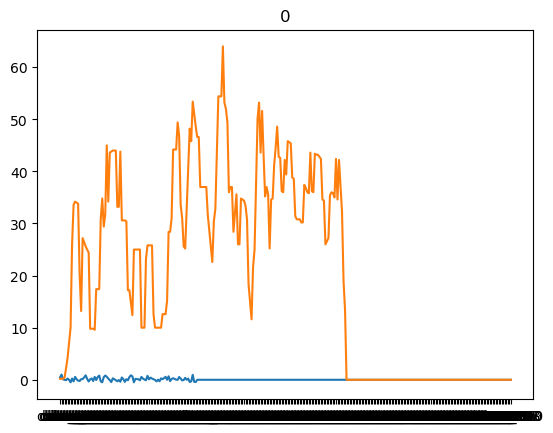

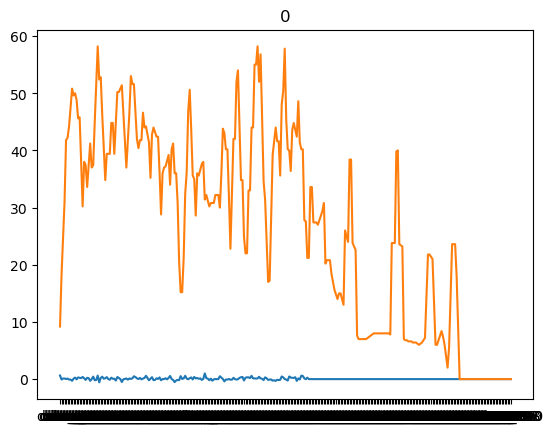

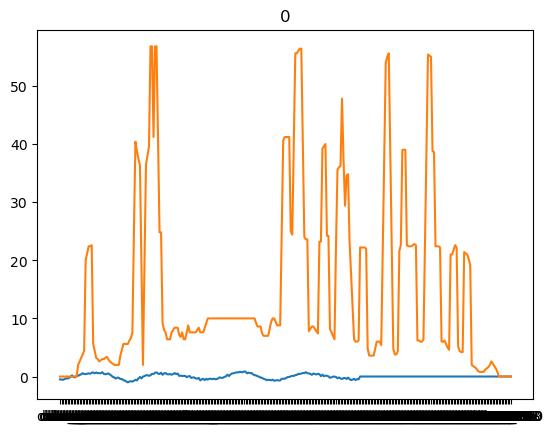

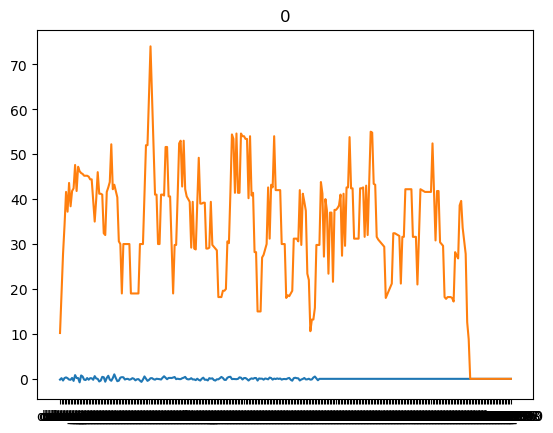

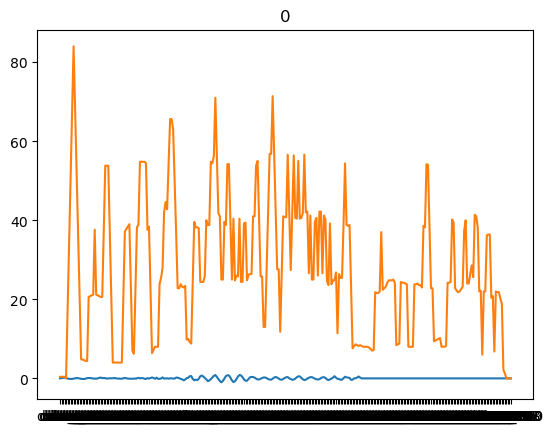

KeyboardInterrupt: 

In [543]:
window_length = 100
for i in range(all_df.shape[0]):
    if all_df.iloc[i,-1] != 2:
        plt.plot(all_df.iloc[i,:-1])
        plt.plot(calculate_primitive_spectrogram(all_df.iloc[i,:-1], window_length))
        plt.title(all_df.iloc[i,-1])
        plt.show()

In [651]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [652]:
X_train = np.concatenate([X_train,X_test ])
y_train = np.concatenate([y_train,y_test])

In [653]:
X_train = ((X_train.T - np.mean(X_train, axis = 1))/np.std(X_train, axis = 1)).T

In [654]:
X_test = ((X_test.T - np.mean(X_test, axis = 1))/np.std(X_test, axis = 1)).T

In [655]:
window_length = 200
fft_array_train = np.zeros(X_train.shape)
for i in range(X_train.shape[0]):
    fft_array_train[i] = calculate_primitive_spectrogram(X_train[i], window_length)

In [656]:
window_length = 200
fft_array_test = np.zeros(X_test.shape)
for i in range(X_test.shape[0]):
    fft_array_test[i] = calculate_primitive_spectrogram(X_test[i], window_length)

In [657]:
X_train = X_train.reshape((-1,1,300))
X_test = X_test.reshape((-1,1,300))
fft_array_train = fft_array_train.reshape((-1,1,300))
fft_array_test = fft_array_test.reshape((-1,1,300))

In [658]:
test = (X_test, fft_array_test, y_test)

In [659]:
trn_sz = 3792
datasets = create_datasets((X_train, fft_array_train), y_train, trn_sz, (X_test, fft_array_test, y_test), valid_pct=0.1, seed=42)

In [624]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [130]:
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [ ]:
def cosine(epoch, t_max, ampl):
    """Shifted and scaled cosine function."""
    
    t = epoch % t_max
    return (1 + np.cos(np.pi*t/t_max))*ampl/2

In [151]:
def inv_cosine(epoch, t_max, ampl):
    """A cosine function reflected on X-axis."""
    
    return 1 - cosine(epoch, t_max, ampl)

In [152]:
def one_cycle(epoch, t_max, a1=0.6, a2=1.0, pivot=0.3):
    """A combined schedule with two cosine half-waves."""
    
    pct = epoch / t_max
    if pct < pivot:
        return inv_cosine(epoch, pivot*t_max, a1)
    return cosine(epoch - pivot*t_max, (1-pivot)*t_max, a2)

In [625]:
class Scheduler:
    """Updates optimizer's learning rates using provided scheduling function."""
    
    def __init__(self, opt, schedule):
        self.opt = opt
        self.schedule = schedule
        self.history = defaultdict(list)
    
    def step(self, t):
        for i, group in enumerate(self.opt.param_groups):
            lr = opt.defaults['lr'] * self.schedule(t)
            group['lr'] = lr
            self.history[i].append(lr)

In [626]:
class SepConv1d(nn.Module):
    """Implementes a 1-d convolution with 'batteries included'.
    
    The module adds (optionally) activation function and dropout 
    layers right after a separable convolution layer.
    """
    def __init__(self, ni, no, kernel, stride, pad, 
                 drop=None, bn=True,
                 activ=lambda: nn.PReLU()):
    
        super().__init__()
        assert drop is None or (0.0 < drop < 1.0)
        layers = [_SepConv1d(ni, no, kernel, stride, pad)]
        if activ:
            layers.append(activ())
        if bn:
            layers.append(nn.BatchNorm1d(no))
        if drop is not None:
            layers.append(nn.Dropout(drop))
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x): 
        return self.layers(x)

In [627]:
class Classifier(nn.Module):
    def __init__(self, raw_ni, fft_ni, no, drop=.5):
        super().__init__()
        
        self.raw = nn.Sequential(
            SepConv1d(raw_ni,  32, 8, 2, 3, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 4, 2, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 2, drop=drop),
            SepConv1d(   128, 128, 3, 1, 1, drop=drop),
            SepConv1d(   128, 256, 8, 4, 2),
            Flatten(),
            nn.Dropout(drop), nn.Linear(512, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.fft = nn.Sequential(
            SepConv1d(fft_ni,  32, 8, 2, 4, drop=drop),
            SepConv1d(    32,  32, 3, 1, 1, drop=drop),
            SepConv1d(    32,  64, 8, 2, 4, drop=drop),
            SepConv1d(    64,  64, 3, 1, 1, drop=drop),
            SepConv1d(    64, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 128, 8, 4, 4, drop=drop),
            SepConv1d(   128, 256, 8, 2, 3),
            Flatten(),
            nn.Dropout(drop), nn.Linear(512+256, 64), nn.PReLU(), nn.BatchNorm1d(64),
            nn.Dropout(drop), nn.Linear( 64, 64), nn.PReLU(), nn.BatchNorm1d(64))
        
        self.out = nn.Sequential(
            nn.Linear(128, 64), nn.ReLU(inplace=True), nn.Linear(64, no))
        
        self.init_weights(nn.init.kaiming_normal_)
        
    def init_weights(self, init_fn):
        def init(m): 
            for child in m.children():
                if isinstance(child, nn.Conv1d):
                    init_fn(child.weights)
        init(self)
        
    def forward(self, t_raw, t_fft):
        raw_out = self.raw(t_raw)
        fft_out = self.fft(t_fft)
        t_in = torch.cat([raw_out, fft_out], dim=1)
        out = self.out(t_in)
        return out

In [663]:
raw_feat = X_array.shape[1]
fft_feat = fft_array.shape[1]

trn_dl, val_dl, tst_dl = create_loaders(datasets, bs=128)

lr = 0.002
n_epochs = 3000
iterations_per_epoch = len(trn_dl)
period = n_epochs*iterations_per_epoch
num_classes = 2
best_acc = 0
patience, trials = 500, 0
base = 1
step = 2
loss_history = []
acc_history = []
iteration = 0


model = Classifier(raw_feat, fft_feat, num_classes).to(device)
criterion = nn.CrossEntropyLoss(reduction='sum')
opt = optim.Adam(model.parameters(), lr=lr)
sched = Scheduler(opt, partial(one_cycle, t_max=period, pivot=0.3))
print('Start model training')

for epoch in range(1, n_epochs + 1):
    
    model.train()
    epoch_loss = 0
    for i, batch in enumerate(trn_dl):
        iteration += 1
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        sched.step(iteration)
        opt.zero_grad()
        out = model(x_raw, x_fft)
        loss = criterion(out, y_batch)
        epoch_loss += loss.item()
        loss.backward()
        opt.step()
        
    epoch_loss /= trn_sz
    loss_history.append(epoch_loss)
    
    model.eval()
    correct, total = 0, 0
    for batch in tst_dl:
        x_raw, x_fft, y_batch = [t.to(device) for t in batch]
        
        out = model(x_raw, x_fft)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += y_batch.size(0)
        correct += (preds == y_batch).sum().item()
    
    acc = correct / total
    acc_history.append(acc)

#     if epoch % base == 0:
#         print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
#         base *= step
    if epoch % 5 ==0:
        print(f'Epoch: {epoch:3d}. Loss: {epoch_loss:.4f}. Acc.: {acc:2.2%}')
    if acc >= best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
            
print('Done!')

Start model training
Epoch 1 best model saved with accuracy: 82.63%
Epoch 2 best model saved with accuracy: 82.63%
Epoch 3 best model saved with accuracy: 82.63%
Epoch 4 best model saved with accuracy: 82.63%
Epoch:   5. Loss: 0.2248. Acc.: 82.63%
Epoch 5 best model saved with accuracy: 82.63%
Epoch 6 best model saved with accuracy: 82.63%
Epoch 7 best model saved with accuracy: 82.63%
Epoch 8 best model saved with accuracy: 83.16%
Epoch 9 best model saved with accuracy: 83.68%
Epoch:  10. Loss: 0.2001. Acc.: 82.89%
Epoch 11 best model saved with accuracy: 83.68%
Epoch 12 best model saved with accuracy: 83.68%
Epoch 13 best model saved with accuracy: 83.68%
Epoch 14 best model saved with accuracy: 83.95%
Epoch:  15. Loss: 0.1830. Acc.: 84.74%
Epoch 15 best model saved with accuracy: 84.74%
Epoch 16 best model saved with accuracy: 85.79%
Epoch 17 best model saved with accuracy: 86.58%
Epoch 18 best model saved with accuracy: 87.63%
Epoch 19 best model saved with accuracy: 87.89%
Epoch: 

Epoch: 335. Loss: 0.0398. Acc.: 99.74%
Epoch 335 best model saved with accuracy: 99.74%
Epoch 336 best model saved with accuracy: 99.74%
Epoch 337 best model saved with accuracy: 99.74%
Epoch 338 best model saved with accuracy: 99.74%
Epoch 339 best model saved with accuracy: 99.74%
Epoch: 340. Loss: 0.0394. Acc.: 99.74%
Epoch 340 best model saved with accuracy: 99.74%
Epoch 341 best model saved with accuracy: 99.74%
Epoch 342 best model saved with accuracy: 99.74%
Epoch 343 best model saved with accuracy: 99.74%
Epoch 344 best model saved with accuracy: 99.74%
Epoch: 345. Loss: 0.0373. Acc.: 99.74%
Epoch 345 best model saved with accuracy: 99.74%
Epoch 346 best model saved with accuracy: 99.74%
Epoch 347 best model saved with accuracy: 99.74%
Epoch 348 best model saved with accuracy: 99.74%
Epoch 349 best model saved with accuracy: 99.74%
Epoch: 350. Loss: 0.0369. Acc.: 99.74%
Epoch 350 best model saved with accuracy: 99.74%
Epoch 351 best model saved with accuracy: 99.74%
Epoch 352 b

Epoch: 1180. Loss: 0.0137. Acc.: 99.21%
Epoch: 1185. Loss: 0.0089. Acc.: 99.74%
Epoch: 1190. Loss: 0.0125. Acc.: 99.74%
Epoch: 1195. Loss: 0.0078. Acc.: 99.74%
Epoch: 1200. Loss: 0.0118. Acc.: 99.74%
Epoch: 1205. Loss: 0.0120. Acc.: 99.74%
Epoch: 1210. Loss: 0.0184. Acc.: 99.74%
Epoch: 1215. Loss: 0.0109. Acc.: 99.74%
Epoch: 1220. Loss: 0.0130. Acc.: 99.74%
Epoch: 1225. Loss: 0.0158. Acc.: 99.74%
Epoch: 1230. Loss: 0.0118. Acc.: 99.74%
Epoch: 1235. Loss: 0.0108. Acc.: 99.74%
Epoch: 1240. Loss: 0.0121. Acc.: 99.74%
Epoch: 1245. Loss: 0.0126. Acc.: 99.74%
Epoch: 1250. Loss: 0.0072. Acc.: 99.74%
Epoch: 1255. Loss: 0.0134. Acc.: 99.47%
Epoch 1259 best model saved with accuracy: 100.00%
Epoch: 1260. Loss: 0.0133. Acc.: 99.74%
Epoch: 1265. Loss: 0.0114. Acc.: 99.74%
Epoch: 1270. Loss: 0.0126. Acc.: 99.74%
Epoch: 1275. Loss: 0.0131. Acc.: 99.74%
Epoch: 1280. Loss: 0.0171. Acc.: 99.74%
Epoch: 1285. Loss: 0.0154. Acc.: 99.74%
Epoch: 1290. Loss: 0.0086. Acc.: 99.74%
Epoch: 1295. Loss: 0.0125. Ac

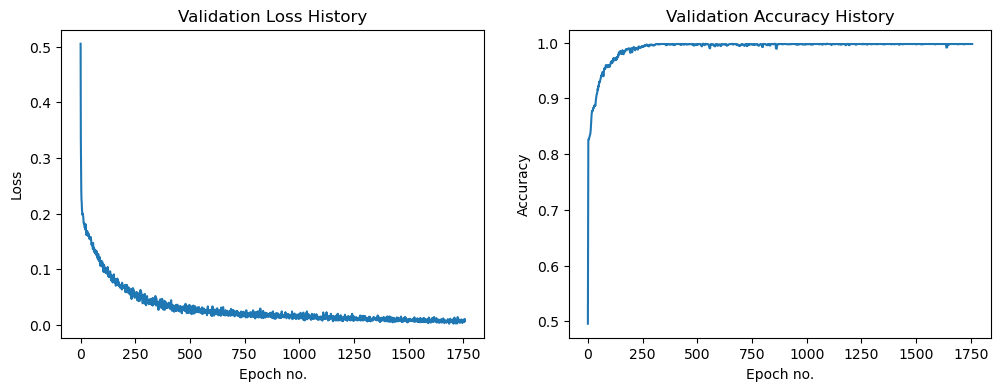

In [664]:
f, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(loss_history, label='loss')
ax[0].set_title('Validation Loss History')
ax[0].set_xlabel('Epoch no.')
ax[0].set_ylabel('Loss')
ax[1].plot(smooth(acc_history, 5)[:-2], label='acc')
ax[1].set_title('Validation Accuracy History')
ax[1].set_xlabel('Epoch no.')
ax[1].set_ylabel('Accuracy');

In [665]:
test_df = pd.read_csv('test_1.csv')

In [666]:
test_df = np.array(test_df.fillna(0))#

In [667]:
test_df = ((test_df.T - np.mean(test_df, axis = 1))/np.std(test_df, axis = 1)).T


In [668]:
window_length = 200
fft_test_df = np.zeros(test_df.shape)
for i in range(test_df.shape[0]):
    fft_test_df[i] = calculate_primitive_spectrogram(test_df[i], window_length)
test_df = test_df.reshape((-1,1,300))
fft_test_df = fft_test_df.reshape((-1,1,300))

In [669]:
tst_ds = TensorDataset(
        torch.tensor(test_df).float(), 
        torch.tensor(fft_test_df).float(), 
        torch.tensor(fft_test_df).long())

In [670]:
model.load_state_dict(torch.load('best.pth'))
model.eval()

Classifier(
  (raw): Sequential(
    (0): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(1, 1, kernel_size=(8,), stride=(2,), padding=(3,))
          (pointwise): Conv1d(1, 32, kernel_size=(1,), stride=(1,))
        )
        (1): PReLU(num_parameters=1)
        (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (1): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), groups=32)
          (pointwise): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
        )
        (1): PReLU(num_parameters=1)
        (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.5, inplace=False)
      )
    )
    (2): SepConv1d(
      (layers): Sequential(
        (0): _SepConv1d(
          (depthwise): Conv1d(32, 32, kern

In [671]:
test_results= []

In [672]:
tst_dl = DataLoader(tst_ds, batch_size=128, shuffle=False, num_workers=0)
for x_raw, x_fft, _ in tst_dl:
    batches = [t.to(device) for t in (x_raw, x_fft)]
    out = model(*batches)
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test_results.extend(y_hat.tolist())

In [673]:
submit = pd.read_csv('submission_sample.csv')
# submit['surface'] = enc.inverse_transform(test_results)
submit['label'] = test_results
submit.to_csv('submit_one_cycle.csv', index=None)

In [674]:
submit_v1 = pd.read_csv('submit_v1_noise.csv')

In [675]:
(submit_v1 == submit).sum()

label    422
dtype: int64

In [676]:
submit

label
0        1
1        1
2        1
3        1
4        1
..     ...
445      1
446      1
447      1
448      0
449      1

[450 rows x 1 columns]